In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
import pandas as pd

In [2]:
def log_results(results, filename, type_): #function to log results. We log into different csv file

    if type_ == '1k_logs': #log of every 1k steps : critic and actor loss
        headers = ['Critic loss', 'Actor loss']  

        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            writer.writerow(results)

    elif type_ == '20k_ep_rewards': #for the evaluation, log the mean of the 10 episodes
        headers = ['Mean episodic reward']  # Add your result names here

        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            writer.writerow(results)
    
    elif type_ == 'ep_reward': #log accumulated reward each time an episode ends along with which step it ended in
        headers = ['Episodic reward', 'Step']  

        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            writer.writerow(results)


In [3]:
class Actor(nn.Module): #class for the actor network, discrete case
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            
            nn.Linear(state_dim,64), #input, first hidden
            nn.Tanh(),
            nn.Linear(64,64), #second hidden layer
            nn.Tanh(),
            nn.Linear(64,n_actions), #output
            nn.Softmax()
        )

    def forward(self, x):
        x = torch.Tensor(x)
        return self.model(x)

In [4]:
class Actor_continuous(nn.Module): #Actor newtork, continuous case

    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64), #input, first hidden
            nn.Tanh(),
            nn.Linear(64,64), #second hidden layer
            nn.Tanh(),
            nn.Linear(64,1) #output : only 1, we return the mean of the normal distribution
        )
        self.log_std = nn.Parameter(torch.zeros(1)) #the log_std is a state independant parameter, initialized at zero

    def forward(self, x):
        x = torch.Tensor(x) 
        mean = self.model(x)
        log_std = self.log_std

        return mean, log_std #we return both the mean and the log of the std

In [5]:
class Critic(nn.Module): #Critic network
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64), #input, first hidden
            nn.Tanh(),
            nn.Linear(64,64), #second hidden layer
            nn.Tanh(),
            nn.Linear(64,1) #output
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [6]:
class A2C_Agent(): #Class for the A2C agent, contains methods to choose action according to policy, get the losses of the networks, update parameters   and do evaluation.

    def __init__(self, n_envs, actor, critic, lr_actor, lr_critic, continuous = False):
        self.n_envs = n_envs
        self.actor = actor #a n agent has one actor network...
        self.critic = critic #... and one critic network
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor) #as well as one optimizer per networks
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
        self.continuous = continuous #parameter to know wether we are in the continuous env
    

    def choose_action(self, states, action_type = "training"): #method to choose an action given a state

        if not self.continuous : 

            if action_type == "training": #when training we return actions, log_probs and state_values
                
                state_values = self.critic(states)#get state values
                action_probs = self.actor(states)#probs#

                actions_pd = torch.distributions.Categorical(probs=action_probs)#create a distribution to sample from
                actions = actions_pd.sample()#choose an action according to the actual policy
                actions_log_prog = actions_pd.log_prob(actions)#comput the log_probs
                
                return actions, actions_log_prog, state_values
            
            elif action_type == 'eval': #in evaluation we use greedy policy
                with torch.no_grad()  :    

                    state_values = self.critic(states)
                    action_probs = self.actor(states)

                    actions = torch.argmax(action_probs) #greedy policy
                return actions, state_values
        
        else :

            if action_type == 'training':

                state_values = self.critic(states)#get state values
                mean, log_std = self.actor(states)#get mean and log_std of the normal distribution to sample from

                normal = torch.distributions.Normal(mean, torch.exp(log_std)) #create a distribution to sample from
                actions = normal.sample()#sample an action
                actions_log_prob = normal.log_prob(actions) #get the log_prob (before clamping)

                actions_r = torch.clamp(actions, -3., 3.) #we don't forget to clamp to get an act readable by the env

                return actions_r, actions_log_prob, state_values
            
            elif action_type == 'eval':
                with torch.no_grad():
                    state_values = self.critic(states)
                    mean, log_std = self.actor(states)

                    actions = mean #in eval we are greedy so we take the most probable action : the mean
                    actions_r = torch.clamp(actions, -3., 3.)
                return actions_r, state_values
        

        
    
    def get_losses(self, rewards, v_states, v_next_states, log_probs, gamma, terminated): #This method computes the loss given collected experience.

        if terminated is not None: #terminated = None means we are in the n_steps case, where we compute the loss a bit differently.
        
            Rt = torch.Tensor(rewards.reshape(self.n_envs,1)) + (1-torch.Tensor(terminated.reshape(self.n_envs,1))) * gamma * (v_next_states).detach() #Rt is reward + gamma * V(st+1), here we bootstrap correctly adding a (1-terminated), we also detach V(st+1) since we don't need these gradients.
            advantage = Rt - v_states

            critic_loss = advantage.pow(2).mean() #take the mean since we can have n environments
            actor_loss = - (advantage.detach() * log_probs.reshape_as(advantage.detach())).mean()

            return actor_loss, critic_loss
        
        else: #used when we do n_steps. Here !!! v_next_states correspond to the discounted rewards at each steps !!!
            advantages = v_next_states.detach() - v_states

            critic_loss = (advantages.pow(2)).mean()
            actor_loss = (-(advantages.detach() * log_probs)).mean()

            return actor_loss, critic_loss
            
    
    def update_params(self, critic_loss, actor_loss): #method to update the parameters using the optimizers
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def evaluate_performance(self): #method to evaluate peformance of the agent every 20k steps : run it on 10 episodes of a new environment.
        
        episodic_rewards_10 = []
        v_values = []

        if self.continuous : 
            env = gym.make("InvertedPendulum-v4")
        else: 
            env = gym.make("CartPole-v1")

        for j in range(10): #we run 10 episodes
            state, _ = env.reset()
            total_reward = 0
            done = False
            while not done:
                action, state_values = self.choose_action(state, action_type= "eval") 
                
                if j == 0 : #we take v values from first episode
                    v_values.append(state_values.detach().data.numpy()) 
                
                #go to the next state
                next_state, reward, terminated, truncated, _  = env.step(action.detach().data.numpy())
                total_reward += reward
                state = next_state
                
                done = terminated or truncated
            episodic_rewards_10.append(total_reward)
        print("episodic return of the 20000:", np.mean(episodic_rewards_10)) #we print to follow
        return np.mean(episodic_rewards_10), v_values
    

In [7]:
def train(seed, filenames, n_envs=1, sparse=False, continuous=False, lr_actor=1e-5): #function to train an agent, with 1 step boostrapping 

    v_values = []
    max_steps = 500000

    if not continuous:
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("CartPole-v1") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]
        n_actions = env.single_action_space.n

        torch.manual_seed(seed)
        actor = Actor(state_dim, n_actions)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=lr_actor, lr_critic=1e-3, continuous=continuous)
    
    else : 
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("InvertedPendulum-v4") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]

        torch.manual_seed(seed)
        actor = Actor_continuous(state_dim)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=lr_actor, lr_critic=1e-3, continuous=continuous)

    
    state = env.reset(seed=seed)[0] #get first state

    ep_reward = [0]*n_envs #variable to store episodic reward of each env played

    for s in tqdm(range(0, max_steps, n_envs)): #we do steps of n_envs

        ## We don't need to reset the environment since we use gym's AsyncEnv ##
        
        actions, actions_log_prog, v_state = agent.choose_action(state) 
        
        next_state, reward, terminated, truncated, info = env.step(actions.numpy())
        st1 = next_state.copy() #we create a copy of next state in order to modify it if the state is truncated, for correct bootstrapping

        for i in range(n_envs):
            ep_reward[i] += reward[i]
            if terminated[i] or truncated[i]: #if env i is terminated or truncated
                st1[i] = info['final_observation'][i] #we retrieve the terminal (terminated or truncated) state to correctly boostrap (doesn't matter for terminated since it zeroed out but it does for truncated)

                log_results([ep_reward[i], s], filenames[3], 'ep_reward') #we log the episode rewards
                ep_reward[i] = 0
        
        if sparse: #if sparse we put the reward at 0 with a probability of 90%
            reward =  np.random.binomial(1, 0.1, size=reward.shape) * reward

        v_st1 = agent.critic(st1) #we compute v_values for the next state, to compute losses

        # terminated = terminated + truncated #uncomment if want uncorrect boostrap
            
        actor_loss, critic_loss = agent.get_losses(reward, v_state, v_st1, actions_log_prog, 0.99, terminated) #compute losses
        state = next_state#update state to next_state (already reset in case of terminal)


        agent.update_params(critic_loss, actor_loss) #we update the parameters
        
        if (s % (round(1000/(n_envs))*n_envs)) == 0: #every 1000k steps (or closer multiple to 1000 of n_envs) we log the losses
            log_results([critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filenames[0], "1k_logs")
            
        if (s % (round(20000/(n_envs))*n_envs) == 0): #every 20000 steps (or multiple) we do 10 episode evaluations and retrieve v values and log rewards
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,500001,20000)] #at the end we log all the v values we got during evaluation into a csv file.
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)



In [8]:
def compute_n_steps_return(gamma, rewards, v_state, terminated): #function to compute n-step discounted returns, given rewards and last state value :  R = rt + gamma*rt+1 + gamma^2*rt+2 + ... + gamma^n * V(st+n)
    r_ = 0
    r = []

    for i in reversed(range(len(rewards))):
        r_ = rewards[i] + gamma*(r_)
        r.insert(0,r_+(1-terminated)*gamma**((len(rewards)-i))*v_state)

    return torch.stack(r)

In [9]:
def train_n(seed, filenames, n_envs=1, n_steps=1, sparse=False, continuous = False, lr_actor=1e-5): #function to train an agent, bootstrapping every n_steps
    v_values = []
    max_steps = 500000

    if not continuous:
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("CartPole-v1") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]
        n_actions = env.single_action_space.n

        torch.manual_seed(seed)
        actor = Actor(state_dim, n_actions)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=lr_actor, lr_critic=1e-3, continuous=continuous)
    
    else : 
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("InvertedPendulum-v4") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]

        torch.manual_seed(seed)
        actor = Actor_continuous(state_dim)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=lr_actor, lr_critic=1e-3, continuous=continuous)
    
    state = env.reset(seed=seed)[0]

    ep_reward = [0]*n_envs #variable to store episodic reward of each env played

    for s in tqdm(range(0,max_steps,n_envs*n_steps)): #we do steps of n_steps * n_envs

        ## We don't need to reset the environment since we use gym's AsyncEnv ##

        rewards_n = torch.zeros((n_steps, n_envs)) #to store rewards from the n steps
        log_probs_n = torch.zeros((n_steps, n_envs)) #to store log probs
        states_n = torch.zeros((n_steps, n_envs)) #to store state values
        discounted_n = torch.zeros((n_steps, n_envs)) #to store discounted returns

        n = 1 #to count steps, could use j below, but a bit more convenient to follow imo
        n_term = [0]*n_envs #to follow where environments terminate/truncate: bc discounted returns are computed per episodes, so we must keep track of where episode end so we don't mix up episodes.

        for j in range(n_steps): #we loop over the n steps

            actions, actions_log_prog, vp = agent.choose_action(state)
            log_probs_n[j] = actions_log_prog.reshape(1, n_envs) #log the log probs
            states_n[j] = vp.reshape(1, n_envs) #and state values
          
            next_state, reward, terminated, truncated, info = env.step(actions.numpy()) #look at next state
            st1 = next_state.copy() #create a copy in case it is terminal so we can have the right state value.

            for i in range(n_envs): 
                ep_reward[i] += reward[i] #update episode rewards for each envs

            if sparse: #we zero the reward with 90% probability
                reward =  np.random.binomial(1, 0.1, size=reward.shape) * reward

            rewards_n[j] = torch.Tensor(reward) #log the reward for the loss computation
            
            for i in range(n_envs):
                if terminated[i] or truncated[i]: #if env i is terminal
                    log_results([ep_reward[i], s], filenames[3], 'ep_reward') #we log episode reward
                    ep_reward[i] = 0

                    st1[i] = info['final_observation'][i]  #we retrieve the terminal state
                    v_st1 = agent.critic(st1[i]) #and compute its state value

                    a = compute_n_steps_return(0.99, rewards_n[n_term[i]:n,i], v_st1, terminated[i])#and we compute the discounted return
                    discounted_n[n_term[i]:n,i] = a.reshape(1,n-n_term[i]) #and log it
                    n_term[i] = n #and update where env i was terminal

        
            if j == n_steps-1: #at the end of the 6 steps, we must compute all of discounted returns
                for i in range(n_envs):
                    if not (terminated[i] or truncated[i]): #if terminal, was computed above so we skip
                        v_st1 = agent.critic(next_state[i]) #we take last state v value
                        a = compute_n_steps_return(0.99, rewards_n[n_term[i]:n,i], v_st1, terminated[i]) #compute the discounted return from last termination point to the end
                        discounted_n[n_term[i]:n,i] = a.reshape(1,n-n_term[i]) #and log it 

            state = next_state #we update the state with the next one
            n += 1

        actor_loss, critic_loss = agent.get_losses(rewards_n, states_n, discounted_n, log_probs_n, 0.99, terminated=None) #at the end of the n steps we compute the losses. Terminated is None to use the right agent's method.

        agent.update_params(critic_loss, actor_loss) #we update the params using the above losses
        
        if (s % (round(1000/(n_steps*n_envs))*n_steps*n_envs)) == 0:#every 1000k steps (or closer multiple to 1000 of n_envs) we log the losses
            log_results([critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filenames[0], "1k_logs")
            
        if (s % (round(20000/(n_steps*n_envs))*n_steps*n_envs) == 0): #every 20000l steps (or multiple) we do 10 evaluation episodes and log the results
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,520001,20000)]#at the end we log all the v values we got during evaluation into a csv file.
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
                        
def plotting(folder_name, seeds): #function to make all the plots for report
    actors  = []
    critics = []
    rewards_20 = []
    v_values = [[] for _ in range(len(seeds))]
    v0 = []
    v1 = []
    v2 = []
    all_rewards = []
    steps = []
    aggregated_seed = []
    aggregated_seed_steps = []
    colors = ['blue', 'green', 'red']
    for i, seed in enumerate(seeds):

        filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]
        # 1)for the loss plot every 1k training steps
        data1 = pd.read_csv(filenames[0])
        actors.append(data1['Actor loss'])
        critics.append(data1['Critic loss'])

        # 2)for the evaluation reward plot every 20k training steps
        data2 = pd.read_csv(filenames[1])
        rewards_20.append(data2['Mean episodic reward'])

        # 3) for the v value plot during evaluation (each of the is the evaluation 1 out of the 10 done)
        data3 = pd.read_csv(filenames[2])

        
        v0.append(data3['V_Values_20000'])  #v_value at begining 
        v1.append(data3['V_Values_260000']) #in the middle
        v2.append(data3['V_Values_480000']) #at the end

        for col in data3.columns:
            v_values[i].append(data3[col].mean())

        #4) for the v value plot over all the column of the evaluation
        data4 = pd.read_csv(filenames[3])
        aggregated = data4.groupby('Step', as_index=False).mean() #in case multiple envs ended at same step, we take the mean
        # 5)for the plot of all episode rewards independently from the env
        all_rewards.append(aggregated['Episodic reward'])

        #6) for the reward plot of the last episodic reward before every 1k steps (so during training)
        steps.append(aggregated['Step'])

        multiples_of_1000 = list(range(1000, 501001, 1000)) #for aggregating seeds, we take the last value for each of them right before each 1k steps, and we will take the mean, min and max of the seeds
        result = []

        for mult in multiples_of_1000:
            filtered_df = aggregated[aggregated['Step'] < mult]
            if not filtered_df.empty:
                last_value = filtered_df.iloc[-1]['Episodic reward']
                result.append({'step': mult, 'value': last_value})

        result_df = pd.DataFrame(result)

        aggregated_seed.append(result_df['value'])
        aggregated_seed_steps.append(result_df['step'])

    #plot 5) does not need any mean-max-mean cause it is independent from the worker
    mean_actors = np.mean(actors, axis=0) #plot 1)
    mean_critics = np.mean(critics, axis=0)#plot 1)
    mean_rewards20 = np.mean(rewards_20, axis=0) #plot 2)    
    mean_vs = np.mean(v_values, axis=0)#plot 6)
    mean_aggr = np.mean(aggregated_seed, axis = 0)
    mean_v0 = np.nanmean(v0, axis=0)
    mean_v1 = np.nanmean(v1, axis=0)
    mean_v2 = np.nanmean(v2, axis=0)

    #for the Vs plots just the mean, no max min
    max_actors = np.max(actors, axis=0)#plot 4) 
    max_critics = np.max(critics, axis=0)#plot 3)
    max_rewards20 = np.max(rewards_20, axis=0)#plot 3)
    max_aggr = np.max(aggregated_seed, axis = 0)#plot 3)

    min_actors = np.min(actors, axis=0)
    min_critics = np.min(critics, axis=0)
    min_rewards20 = np.min(rewards_20, axis=0)
    min_aggr = np.min(aggregated_seed, axis=0)

    #plot 1 actor loss ( a) plot report)
    plt.plot(range(len(mean_actors)), mean_actors, color='blue', marker='x', linestyle='', label='Mean')
    plt.fill_between(range(len(mean_actors)), min_actors, max_actors, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Actor loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Actor.jpg'), dpi=300)

    #plot 1 critic loss ( b) plot report)
    plt.figure()
    plt.plot(range(len(mean_critics)), mean_critics, color='blue', marker='x', label='Mean')
    plt.fill_between(range(len(mean_critics)), min_critics, max_critics, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Critic loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Critic.jpg'), dpi=300)

    #plot 2 evaluation rewards ( d) plot report)
    plt.figure()
    plt.plot(range(len(mean_rewards20)), mean_rewards20, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards20)), min_rewards20, max_rewards20, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 20000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_20k.jpg'), dpi=300)

    #plot 4 ( f) plot report)
    plt.figure()
    plt.plot(range(len(mean_vs)), mean_vs, color='blue', label='Mean')
    plt.xlabel('Step * 20000')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Values.jpg'), dpi=300)

    #plot 5 per seed
    for i in range(len(seeds)):
        plt.figure()
        plt.plot(steps[i], all_rewards[i], 'x')
        plt.xlabel('')
        plt.ylabel('Episodic Reward')
        plt.savefig(os.path.join(folder_name, str(seeds[i])+'_Ep_Rewards.jpg'), dpi=300)

    #plt 3 version for each seed 
    plt.figure()
    for i in range(len(seeds)):
        plt.plot(range(len(v0[i])), (v0[i]), color=colors[i], label='Seed '+str(i))
        plt.xlabel('Step')
        plt.ylabel('Value function')
        plt.ylim(0,101)
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Value20k.jpg'), dpi=300)

    plt.figure()
    for i in range(len(seeds)):
        plt.plot(range(len(v1[i])), (v1[i]), color=colors[i], label='Seed '+str(i))
        plt.xlabel('Step')
        plt.ylabel('Value function')
        plt.ylim(0,101)
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Values260k.jpg'), dpi=300)

    plt.figure()
    for i in range(len(seeds)):
        plt.plot(range(len(v2[i])), (v2[i]), color=colors[i], label='Seed '+str(i))
        plt.xlabel('Step')
        plt.ylabel('Value function')
        plt.ylim(0,101)
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Value480k.jpg'), dpi=300)

    #plot 3 version taking the mean between each seed ( e) plot report)
    plt.figure()
    plt.plot(range(len(mean_v0)), mean_v0, color=colors[0], label='20k steps')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,101)

    plt.plot(range(len(mean_v1)), mean_v1, color=colors[1], label='260k steps')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,101)

    plt.plot(range(len(mean_v2)), mean_v2, color=colors[2], label='480k steps')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,101)

    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Values_mean.jpg'), dpi=300)

    #plot 6: episodic reward (last every 1000 steps)--> training rewards: it is per seed ( c) plot report)
    plt.figure()
    plt.plot(range(len(mean_aggr)), mean_aggr, color='blue', label='Mean')
    plt.fill_between(range(len(mean_aggr)), min_aggr, max_aggr, color='gray', alpha=0.3, label='Min-Max Range')
    plt.xlabel('Step * 1000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_Aggr.jpg'), dpi=300)

## Agent 0 : 1 env, 1 step, non sparse rewards

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1_1_nonSparse'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=False)

  0%|          | 0/500000 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 19/500000 [00:00<1:18:30, 106.14it/s]

episodic return of the 20000: 9.6


  4%|▍         | 20030/500000 [01:37<1:00:02, 133.25it/s]

episodic return of the 20000: 239.7


  8%|▊         | 40040/500000 [02:53<1:21:59, 93.50it/s] 

episodic return of the 20000: 462.8


 12%|█▏        | 60059/500000 [04:09<1:20:29, 91.10it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80033/500000 [05:27<1:17:28, 90.35it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100035/500000 [06:45<1:21:41, 81.60it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120033/500000 [08:07<1:15:20, 84.06it/s] 

episodic return of the 20000: 486.8


 28%|██▊       | 140045/500000 [09:53<1:15:21, 79.60it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160024/500000 [11:16<1:39:11, 57.12it/s]

episodic return of the 20000: 482.2


 36%|███▌      | 180042/500000 [12:37<1:03:50, 83.53it/s]

episodic return of the 20000: 487.2


 40%|████      | 200023/500000 [14:06<1:19:56, 62.54it/s]

episodic return of the 20000: 480.5


 44%|████▍     | 220029/500000 [15:31<1:11:15, 65.49it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240042/500000 [16:54<53:13, 81.40it/s]  

episodic return of the 20000: 489.5


 52%|█████▏    | 260032/500000 [18:17<50:30, 79.19it/s]  

episodic return of the 20000: 490.7


 56%|█████▌    | 280040/500000 [19:40<45:05, 81.30it/s] 

episodic return of the 20000: 500.0


 60%|██████    | 300030/500000 [21:05<38:53, 85.68it/s] 

episodic return of the 20000: 460.2


 64%|██████▍   | 320035/500000 [22:29<36:37, 81.91it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340045/500000 [23:51<28:38, 93.08it/s] 

episodic return of the 20000: 406.5


 72%|███████▏  | 360046/500000 [25:23<29:52, 78.10it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380028/500000 [27:01<28:05, 71.16it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400036/500000 [28:23<21:15, 78.40it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 420032/500000 [29:44<17:10, 77.58it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440047/500000 [31:07<12:07, 82.39it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460050/500000 [32:28<08:18, 80.18it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480039/500000 [33:51<04:08, 80.32it/s] 

episodic return of the 20000: 500.0


  0%|          | 17/500000 [00:00<1:34:23, 88.28it/s]

episodic return of the 20000: 13.1


  4%|▍         | 20025/500000 [01:22<2:34:36, 51.74it/s] 

episodic return of the 20000: 339.7


  8%|▊         | 40043/500000 [02:43<1:33:42, 81.80it/s] 

episodic return of the 20000: 500.0


 12%|█▏        | 60047/500000 [04:06<1:32:39, 79.13it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80047/500000 [05:26<1:25:58, 81.41it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100050/500000 [06:48<1:21:38, 81.65it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120029/500000 [08:09<1:17:01, 82.22it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 140035/500000 [09:30<1:12:58, 82.21it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160007/500000 [10:51<1:45:46, 53.57it/s]

episodic return of the 20000: 500.0


 36%|███▌      | 180031/500000 [12:12<1:34:31, 56.42it/s]

episodic return of the 20000: 500.0


 40%|████      | 200026/500000 [13:33<1:06:29, 75.19it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220032/500000 [14:54<58:28, 79.80it/s]  

episodic return of the 20000: 500.0


 48%|████▊     | 240029/500000 [16:14<35:48, 121.00it/s]

episodic return of the 20000: 251.6


 52%|█████▏    | 260033/500000 [17:35<53:02, 75.40it/s]  

episodic return of the 20000: 500.0


 56%|█████▌    | 280050/500000 [18:55<47:28, 77.21it/s]  

episodic return of the 20000: 500.0


 60%|██████    | 300047/500000 [20:16<41:53, 79.55it/s] 

episodic return of the 20000: 500.0


 64%|██████▍   | 320037/500000 [21:39<36:34, 81.99it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340026/500000 [23:00<33:52, 78.72it/s] 

episodic return of the 20000: 500.0


 72%|███████▏  | 360035/500000 [24:44<31:36, 73.81it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380044/500000 [26:06<24:13, 82.54it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400034/500000 [27:27<21:24, 77.81it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 420040/500000 [28:51<16:42, 79.77it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440026/500000 [30:15<12:40, 78.87it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460026/500000 [31:38<10:43, 62.16it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480028/500000 [33:00<04:12, 78.94it/s] 

episodic return of the 20000: 500.0


  0%|          | 43/500000 [00:00<37:49, 220.27it/s]

episodic return of the 20000: 8.9


  4%|▍         | 20046/500000 [01:25<1:16:04, 105.16it/s]

episodic return of the 20000: 335.2


  8%|▊         | 40038/500000 [02:46<1:28:07, 87.00it/s] 

episodic return of the 20000: 465.2


 12%|█▏        | 60029/500000 [04:07<1:30:58, 80.60it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80055/500000 [05:27<1:16:58, 90.92it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100024/500000 [06:59<2:11:41, 50.62it/s]

episodic return of the 20000: 495.1


 24%|██▍       | 120034/500000 [08:23<1:19:20, 79.82it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 140021/500000 [09:46<1:23:29, 71.86it/s]

episodic return of the 20000: 500.0


 32%|███▏      | 160038/500000 [11:08<1:48:18, 52.31it/s]

episodic return of the 20000: 485.7


 36%|███▌      | 180041/500000 [12:30<1:04:07, 83.17it/s]

episodic return of the 20000: 483.4


 40%|████      | 200041/500000 [13:52<1:05:34, 76.23it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220039/500000 [15:15<54:03, 86.30it/s]  

episodic return of the 20000: 437.6


 48%|████▊     | 240052/500000 [16:37<53:07, 81.55it/s]  

episodic return of the 20000: 474.0


 52%|█████▏    | 260033/500000 [17:59<1:16:18, 52.41it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 280038/500000 [19:26<42:35, 86.07it/s]  

episodic return of the 20000: 461.8


 60%|██████    | 300037/500000 [20:48<41:15, 80.77it/s] 

episodic return of the 20000: 478.6


 64%|██████▍   | 319988/500000 [22:31<12:22, 242.37it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 340049/500000 [24:01<34:05, 78.18it/s]  

episodic return of the 20000: 500.0


 72%|███████▏  | 360033/500000 [25:25<28:50, 80.89it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380030/500000 [26:48<35:27, 56.39it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400023/500000 [27:57<20:11, 82.51it/s] 

episodic return of the 20000: 459.2


 84%|████████▍ | 420041/500000 [28:59<08:43, 152.76it/s]

episodic return of the 20000: 390.3


 88%|████████▊ | 440046/500000 [30:02<07:50, 127.39it/s]

episodic return of the 20000: 498.0


 92%|█████████▏| 460058/500000 [31:09<05:13, 127.32it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 480026/500000 [32:12<05:08, 64.76it/s] 

episodic return of the 20000: 500.0


100%|██████████| 500000/500000 [33:16<00:00, 250.44it/s]


[0.10184412680000002, 42.460407576923075, 68.046442598, 92.264742804, 91.804444962, 100.007046198, 100.002418566, 99.99937274, 100.00048695999998, 100.00284000000002, 100.00420874000001, 99.45463294399998, 99.833903308, 100.023991106, 100.002958836, 100.004623204, 100.00338414799998, 90.22179452040817, 100.002053924, 100.00129949, 99.99890062000003, 99.99458986, 99.99515985999999, 100.00121245800003, 99.99706]


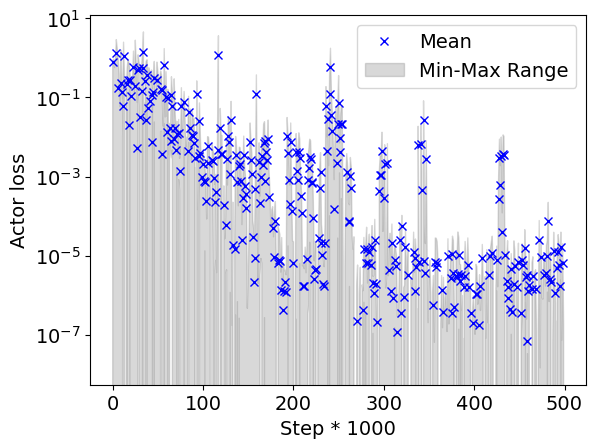

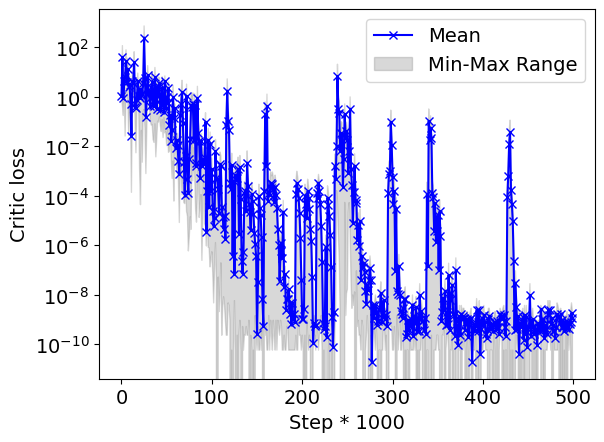

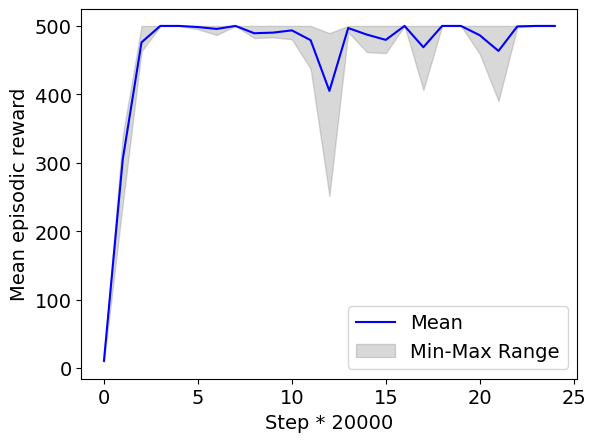

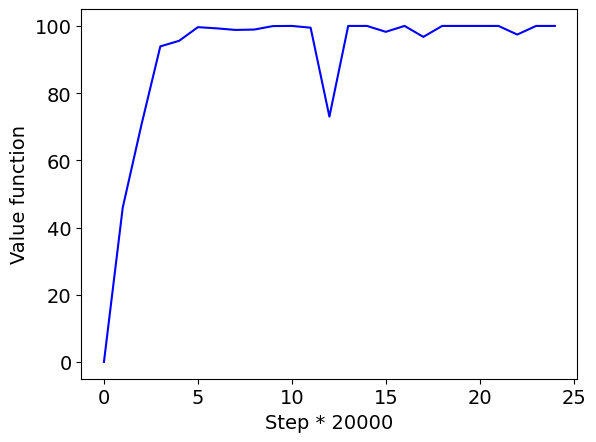

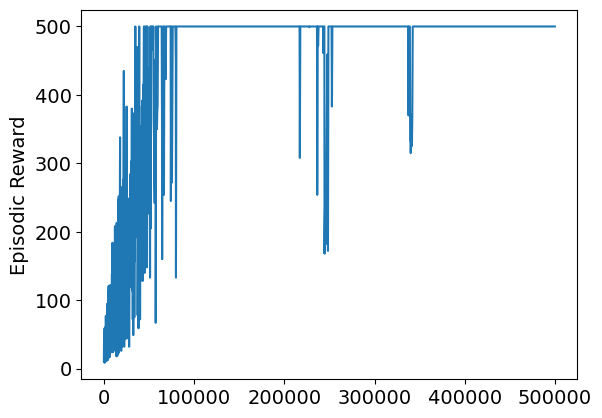

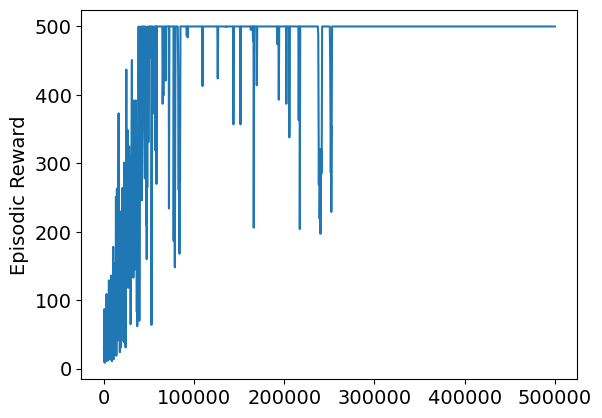

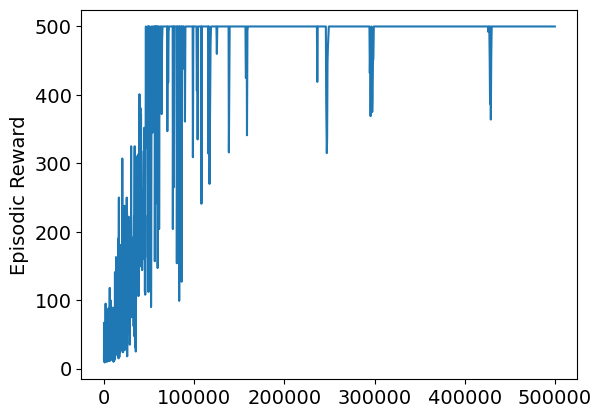

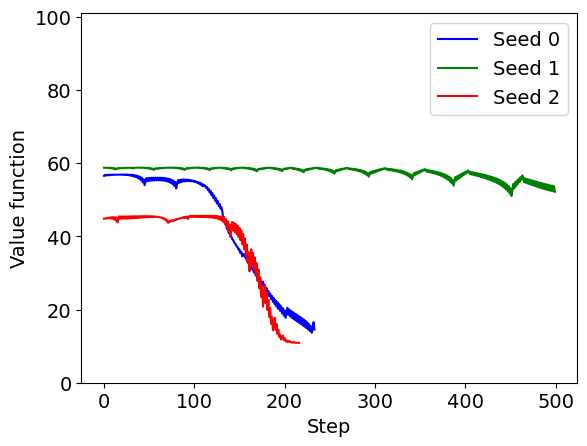

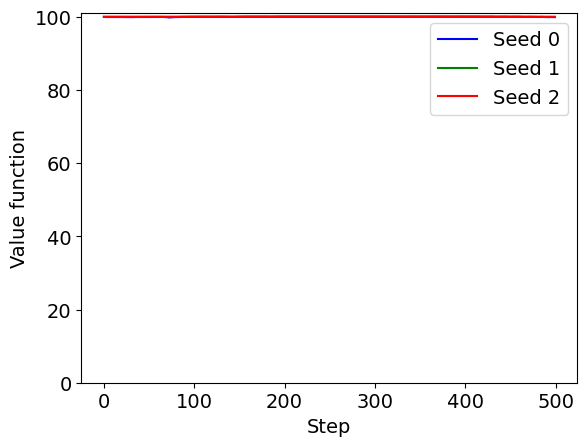

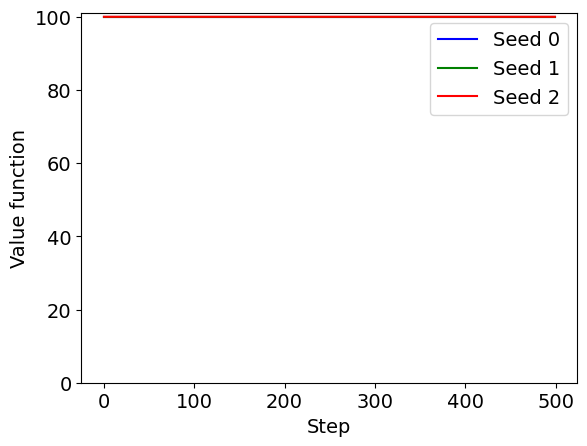

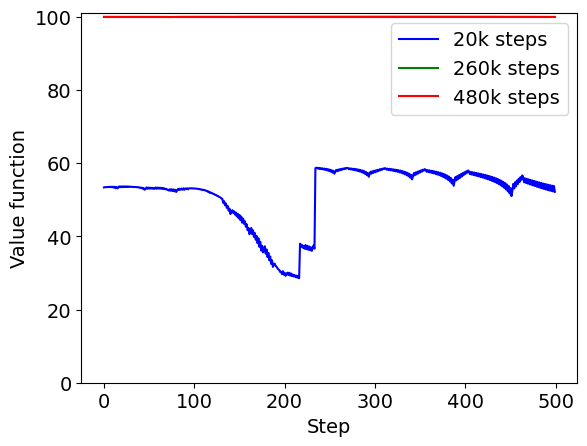

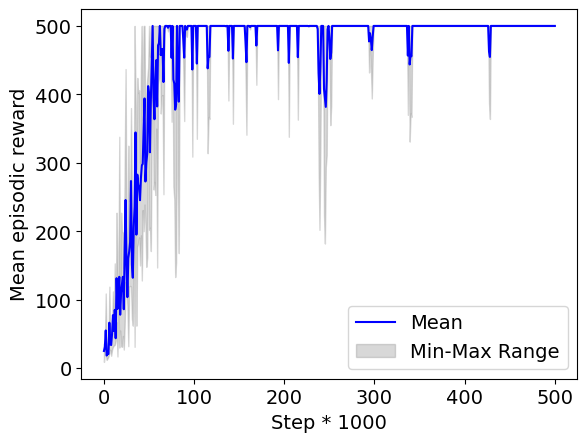

In [104]:
folder_name = 'Results_1_1_nonSparse' 
### Here the figures don't correspond to the ones in the report bc it was run on another computer and gave better results so we kept it (we tried with the following agents and it didn't improve) ###
plotting(folder_name, seeds) 

## Agent 1 : 1env, 1step, sparse rewards

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1_1_Sparse'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=True)

  0%|          | 0/500000 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 25/500000 [00:00<1:01:36, 135.26it/s]

episodic return of the 20000: 9.9


  4%|▍         | 20038/500000 [01:04<42:18, 189.10it/s]  

episodic return of the 20000: 124.7


  8%|▊         | 40017/500000 [02:24<2:03:13, 62.21it/s] 

episodic return of the 20000: 287.5


 12%|█▏        | 60053/500000 [03:29<49:38, 147.71it/s]  

episodic return of the 20000: 406.0


 16%|█▌        | 80054/500000 [04:32<1:04:35, 108.37it/s]

episodic return of the 20000: 500.0


 20%|██        | 100044/500000 [05:42<1:03:27, 105.04it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120041/500000 [06:54<2:23:55, 44.00it/s] 

episodic return of the 20000: 494.4


 28%|██▊       | 140007/500000 [08:24<1:50:06, 54.49it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160038/500000 [09:51<1:12:05, 78.59it/s]

episodic return of the 20000: 461.1


 36%|███▌      | 180031/500000 [11:18<1:00:41, 87.87it/s]

episodic return of the 20000: 300.9


 40%|████      | 200042/500000 [12:43<1:05:31, 76.30it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220031/500000 [14:11<1:18:31, 59.43it/s]

episodic return of the 20000: 495.1


 48%|████▊     | 240048/500000 [15:43<58:47, 73.70it/s]  

episodic return of the 20000: 500.0


 52%|█████▏    | 260032/500000 [17:12<1:04:16, 62.23it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 280044/500000 [18:41<49:25, 74.16it/s]  

episodic return of the 20000: 500.0


 60%|██████    | 300039/500000 [20:22<54:52, 60.74it/s]  

episodic return of the 20000: 500.0


 64%|██████▍   | 320025/500000 [22:52<1:11:08, 42.16it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 340015/500000 [24:57<1:42:50, 25.93it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 360037/500000 [26:59<51:48, 45.03it/s]  

episodic return of the 20000: 500.0


 76%|███████▌  | 380033/500000 [28:53<1:05:45, 30.41it/s]

episodic return of the 20000: 500.0


 80%|████████  | 400039/500000 [30:41<19:58, 83.38it/s]  

episodic return of the 20000: 500.0


 84%|████████▍ | 420021/500000 [32:43<31:44, 42.00it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440046/500000 [34:32<15:28, 64.59it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460039/500000 [36:07<09:51, 67.57it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480031/500000 [37:47<08:23, 39.65it/s] 

episodic return of the 20000: 500.0


  0%|          | 13/500000 [00:00<2:11:50, 63.20it/s]

episodic return of the 20000: 12.0


  4%|▍         | 20027/500000 [01:59<1:17:28, 103.24it/s]

episodic return of the 20000: 193.4


  8%|▊         | 40025/500000 [03:45<2:30:39, 50.88it/s] 

episodic return of the 20000: 477.0


 12%|█▏        | 60032/500000 [05:41<3:22:48, 36.16it/s] 

episodic return of the 20000: 490.6


 16%|█▌        | 80033/500000 [07:28<1:49:59, 63.63it/s] 

episodic return of the 20000: 480.5


 20%|██        | 100030/500000 [09:21<1:56:18, 57.32it/s]

episodic return of the 20000: 484.9


 24%|██▍       | 120025/500000 [10:59<1:38:35, 64.23it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 140042/500000 [12:36<1:28:24, 67.86it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160031/500000 [14:10<1:29:56, 62.99it/s]

episodic return of the 20000: 500.0


 36%|███▌      | 180037/500000 [15:45<1:59:13, 44.73it/s]

episodic return of the 20000: 489.5


 40%|████      | 200013/500000 [17:21<1:45:26, 47.42it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220038/500000 [18:58<1:14:43, 62.44it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240028/500000 [20:37<1:05:00, 66.65it/s]

episodic return of the 20000: 494.1


 52%|█████▏    | 260029/500000 [22:11<55:42, 71.80it/s]  

episodic return of the 20000: 450.9


 56%|█████▌    | 280031/500000 [23:47<1:01:34, 59.54it/s]

episodic return of the 20000: 500.0


 60%|██████    | 300026/500000 [25:25<52:20, 63.68it/s]  

episodic return of the 20000: 500.0


 64%|██████▍   | 320025/500000 [27:01<43:44, 68.56it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340021/500000 [28:34<48:54, 54.51it/s] 

episodic return of the 20000: 500.0


 72%|███████▏  | 360034/500000 [30:29<39:44, 58.70it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380022/500000 [32:12<35:47, 55.87it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400044/500000 [33:55<26:53, 61.93it/s] 

episodic return of the 20000: 493.1


 84%|████████▍ | 420025/500000 [35:40<24:06, 55.30it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440030/500000 [37:26<17:15, 57.89it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460028/500000 [39:10<11:55, 55.83it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480031/500000 [40:57<06:03, 55.00it/s] 

episodic return of the 20000: 500.0


  0%|          | 32/500000 [00:00<55:59, 148.81it/s]  

episodic return of the 20000: 9.5


  4%|▍         | 20029/500000 [01:58<58:33, 136.62it/s]  

episodic return of the 20000: 94.8


  8%|▊         | 40034/500000 [03:49<2:15:36, 56.53it/s] 

episodic return of the 20000: 478.6


 12%|█▏        | 60033/500000 [05:38<3:17:20, 37.16it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80024/500000 [07:25<2:31:49, 46.10it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100023/500000 [09:09<4:58:33, 22.33it/s]

episodic return of the 20000: 488.8


 24%|██▍       | 120027/500000 [11:10<1:51:26, 56.83it/s] 

episodic return of the 20000: 495.1


 28%|██▊       | 140003/500000 [13:00<2:16:02, 44.10it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160033/500000 [14:54<1:27:50, 64.51it/s]

episodic return of the 20000: 500.0


 36%|███▌      | 180048/500000 [16:38<1:14:42, 71.37it/s]

episodic return of the 20000: 500.0


 40%|████      | 200029/500000 [18:15<1:35:12, 52.51it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220001/500000 [19:48<1:39:51, 46.73it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240003/500000 [21:24<1:27:41, 49.41it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 260032/500000 [22:54<48:30, 82.45it/s]  

episodic return of the 20000: 500.0


 56%|█████▌    | 280039/500000 [24:18<1:04:49, 56.55it/s]

episodic return of the 20000: 500.0


 60%|██████    | 300047/500000 [25:41<39:29, 84.39it/s]  

episodic return of the 20000: 500.0


 64%|██████▍   | 320042/500000 [27:05<39:57, 75.05it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340038/500000 [28:45<46:53, 56.85it/s]  

episodic return of the 20000: 500.0


 72%|███████▏  | 360023/500000 [30:16<17:53, 130.43it/s]

episodic return of the 20000: 147.5


 76%|███████▌  | 380036/500000 [31:53<19:20, 103.37it/s]

episodic return of the 20000: 160.7


 80%|████████  | 400041/500000 [33:36<14:45, 112.93it/s]

episodic return of the 20000: 170.6


 84%|████████▍ | 420027/500000 [35:14<26:27, 50.36it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440036/500000 [36:57<17:06, 58.44it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460013/500000 [38:46<11:24, 58.39it/s] 

episodic return of the 20000: 137.9


 96%|█████████▌| 480028/500000 [40:30<02:16, 146.13it/s]

episodic return of the 20000: 129.9


100%|██████████| 500000/500000 [42:06<00:00, 197.92it/s]


      Episodic reward    Step
0                11.0      10
1                34.0      44
2                20.0      64
3                10.0      74
4                83.0     157
...               ...     ...
1722            500.0  497553
1723            500.0  498053
1724            500.0  498553
1725            500.0  499053
1726            500.0  499553

[1727 rows x 2 columns]
        Step  Episodic reward
0         10             11.0
1         44             34.0
2         64             20.0
3         74             10.0
4        157             83.0
...      ...              ...
1722  497553            500.0
1723  498053            500.0
1724  498553            500.0
1725  499053            500.0
1726  499553            500.0

[1727 rows x 2 columns]
      Episodic reward    Step
0                31.0      30
1                33.0      63
2                24.0      87
3                17.0     104
4                26.0     130
...               ...     ...
1596            291.

/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_62722/4288361268.py:67: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


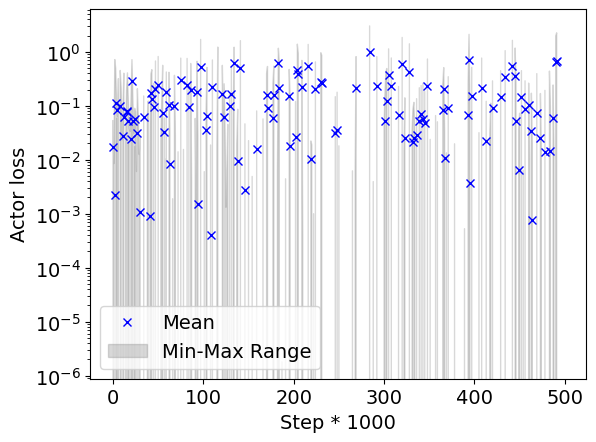

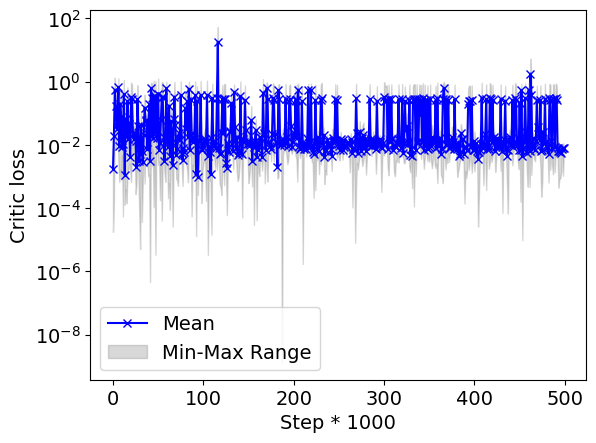

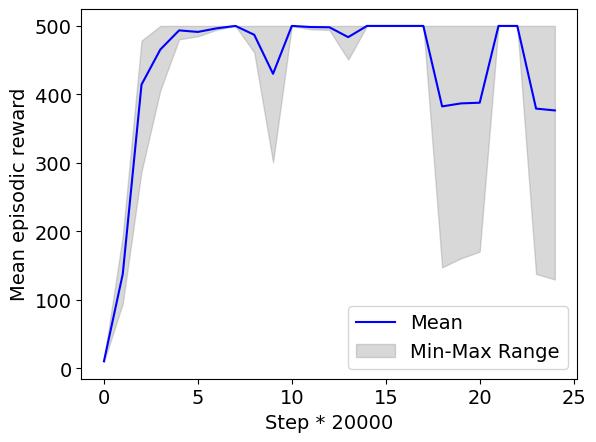

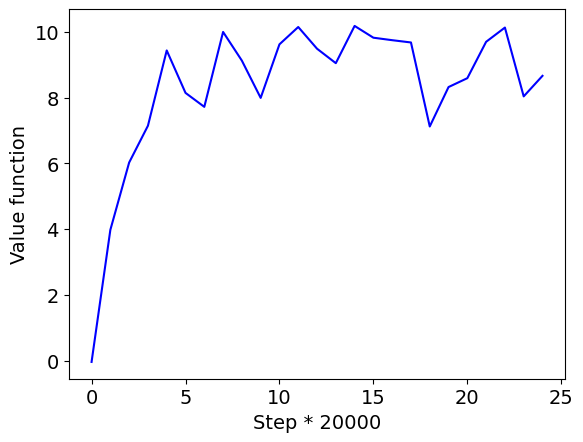

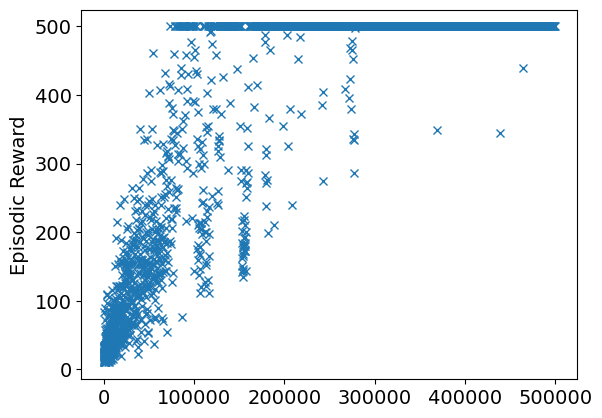

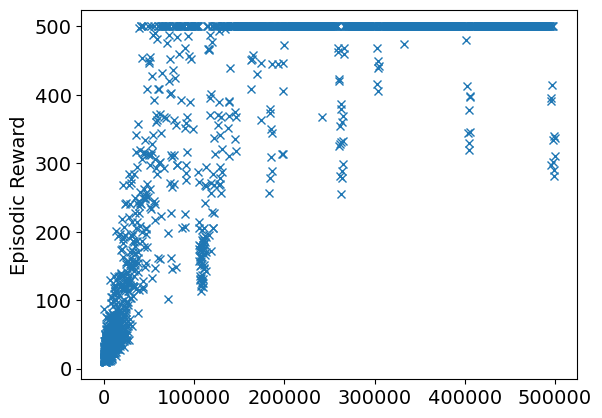

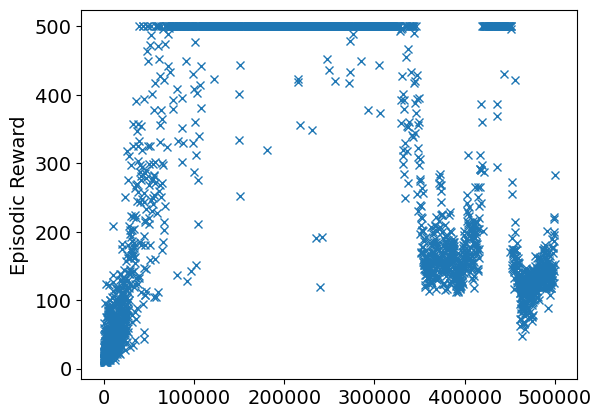

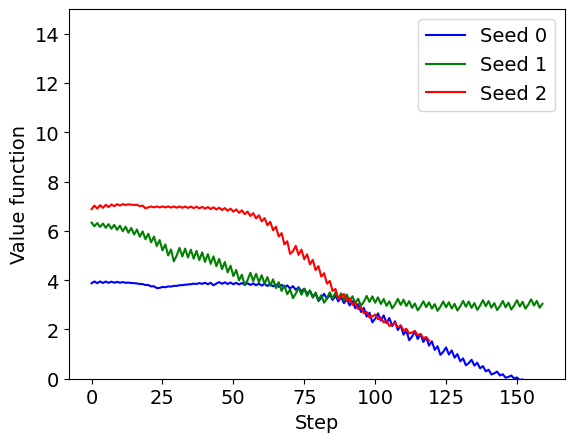

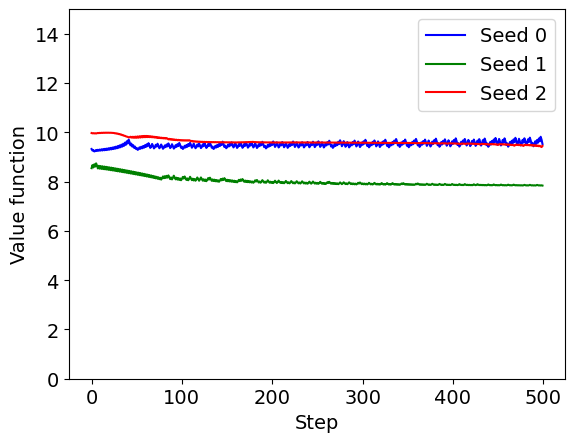

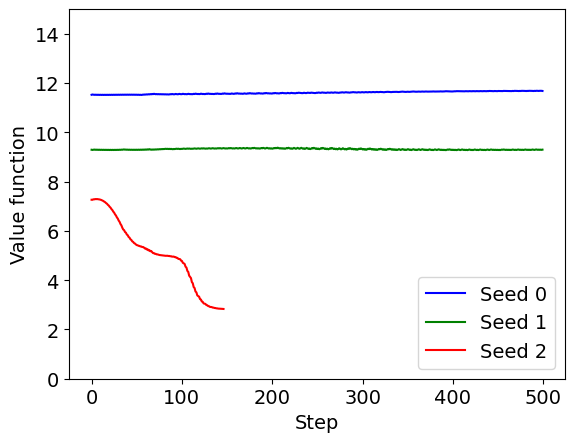

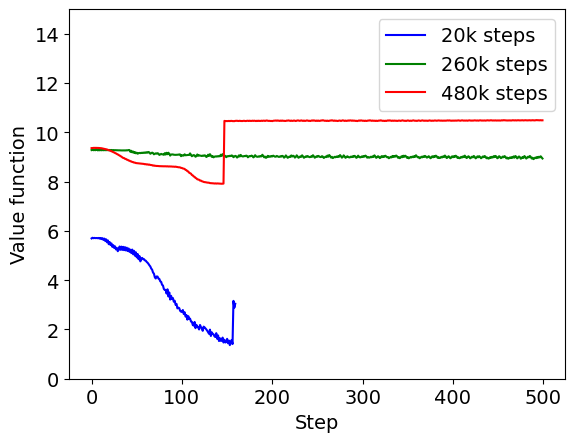

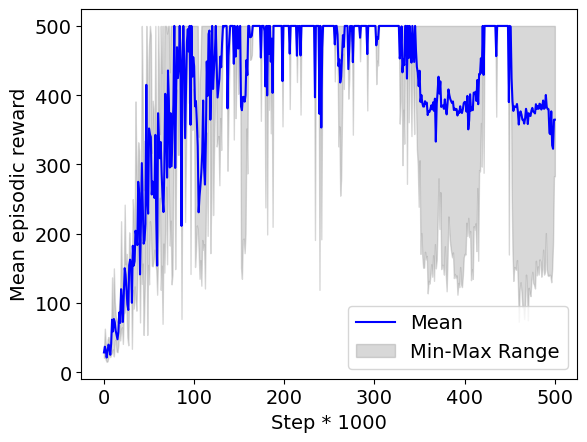

In [14]:
folder_name = 'Results_1_1_Sparse'
plotting(folder_name, seeds)

## Agent 2: 6 envs, 1 step

In [17]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_6env_1step'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=6, sparse=True)

  0%|          | 0/83334 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 30/83334 [00:00<08:58, 154.82it/s]

episodic return of the 20000: 9.3


  4%|▍         | 3374/83334 [00:18<08:25, 158.10it/s]

episodic return of the 20000: 73.4


  8%|▊         | 6698/83334 [00:36<10:24, 122.71it/s]

episodic return of the 20000: 169.9


 12%|█▏        | 10023/83334 [00:53<14:51, 82.26it/s]

episodic return of the 20000: 360.8


 16%|█▌        | 13371/83334 [01:10<16:51, 69.19it/s] 

episodic return of the 20000: 497.3


 20%|█▉        | 16662/83334 [01:26<04:57, 223.95it/s]

episodic return of the 20000: 490.8


 24%|██▍       | 20025/83334 [01:48<28:05, 37.55it/s] 

episodic return of the 20000: 415.3


 28%|██▊       | 23352/83334 [02:07<20:54, 47.80it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 26698/83334 [02:26<13:48, 68.32it/s] 

episodic return of the 20000: 462.1


 36%|███▌      | 30029/83334 [02:45<14:43, 60.34it/s] 

episodic return of the 20000: 480.0


 40%|████      | 33359/83334 [03:03<13:13, 63.02it/s] 

episodic return of the 20000: 500.0


 44%|████▍     | 36697/83334 [03:22<13:26, 57.81it/s] 

episodic return of the 20000: 478.4


 48%|████▊     | 40019/83334 [03:44<16:27, 43.85it/s] 

episodic return of the 20000: 500.0


 52%|█████▏    | 43320/83334 [04:05<03:09, 210.84it/s]

episodic return of the 20000: 479.7


 56%|█████▌    | 46692/83334 [04:27<09:13, 66.23it/s] 

episodic return of the 20000: 446.2


 60%|██████    | 50016/83334 [04:46<11:11, 49.59it/s] 

episodic return of the 20000: 500.0


 64%|██████▍   | 53345/83334 [05:07<13:08, 38.02it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 56674/83334 [05:30<08:41, 51.09it/s] 

episodic return of the 20000: 405.7


 72%|███████▏  | 60025/83334 [05:48<05:18, 73.08it/s] 

episodic return of the 20000: 467.4


 76%|███████▌  | 63361/83334 [06:08<04:44, 70.17it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 66677/83334 [06:25<06:25, 43.23it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 70030/83334 [06:45<03:56, 56.18it/s] 

episodic return of the 20000: 492.7


 88%|████████▊ | 73346/83334 [07:05<03:01, 54.92it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 76691/83334 [07:27<01:35, 69.47it/s] 

episodic return of the 20000: 494.3


 96%|█████████▌| 80023/83334 [07:45<00:53, 61.75it/s] 

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [08:05<00:00, 171.80it/s]

episodic return of the 20000: 500.0



  0%|          | 31/83334 [00:00<08:43, 159.25it/s]

episodic return of the 20000: 13.3


  4%|▍         | 3368/83334 [00:19<10:21, 128.73it/s]

episodic return of the 20000: 108.1


  8%|▊         | 6690/83334 [00:40<16:25, 77.74it/s] 

episodic return of the 20000: 232.9


 12%|█▏        | 10032/83334 [00:57<18:41, 65.37it/s]

episodic return of the 20000: 357.0


 16%|█▌        | 13373/83334 [01:16<18:10, 64.15it/s] 

episodic return of the 20000: 453.6


 20%|██        | 16697/83334 [01:35<18:23, 60.40it/s] 

episodic return of the 20000: 483.7


 24%|██▍       | 20022/83334 [01:55<21:01, 50.18it/s] 

episodic return of the 20000: 497.6


 28%|██▊       | 23337/83334 [02:14<24:51, 40.23it/s] 

episodic return of the 20000: 493.9


 32%|███▏      | 26698/83334 [02:36<22:59, 41.04it/s] 

episodic return of the 20000: 500.0


 36%|███▌      | 30039/83334 [02:55<14:16, 62.23it/s] 

episodic return of the 20000: 494.1


 40%|████      | 33359/83334 [03:14<14:45, 56.44it/s] 

episodic return of the 20000: 490.9


 44%|████▍     | 36704/83334 [03:33<11:08, 69.78it/s] 

episodic return of the 20000: 500.0


 48%|████▊     | 40024/83334 [03:53<20:07, 35.87it/s] 

episodic return of the 20000: 500.0


 52%|█████▏    | 43345/83334 [04:13<15:58, 41.74it/s] 

episodic return of the 20000: 500.0


 56%|█████▌    | 46683/83334 [04:32<11:36, 52.60it/s] 

episodic return of the 20000: 500.0


 60%|██████    | 50020/83334 [04:50<10:10, 54.55it/s] 

episodic return of the 20000: 500.0


 64%|██████▍   | 53322/83334 [05:06<02:16, 219.12it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 56693/83334 [05:27<12:08, 36.56it/s] 

episodic return of the 20000: 500.0


 72%|███████▏  | 60018/83334 [05:51<06:54, 56.28it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 63354/83334 [06:12<08:12, 40.53it/s] 

episodic return of the 20000: 496.9


 80%|████████  | 66689/83334 [06:34<05:25, 51.06it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 70016/83334 [06:52<03:39, 60.64it/s] 

episodic return of the 20000: 460.8


 88%|████████▊ | 73340/83334 [07:14<05:08, 32.35it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 76690/83334 [07:34<01:58, 55.90it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 80029/83334 [07:54<00:56, 58.95it/s] 

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [08:14<00:00, 168.43it/s]

episodic return of the 20000: 495.6



  0%|          | 27/83334 [00:00<09:46, 142.14it/s]

episodic return of the 20000: 9.5


  4%|▍         | 3353/83334 [00:19<11:46, 113.17it/s]

episodic return of the 20000: 78.9


  8%|▊         | 6701/83334 [00:38<13:01, 98.05it/s] 

episodic return of the 20000: 217.8


 12%|█▏        | 10024/83334 [00:58<27:11, 44.93it/s]

episodic return of the 20000: 446.3


 16%|█▌        | 13364/83334 [01:18<22:47, 51.16it/s] 

episodic return of the 20000: 488.6


 20%|██        | 16690/83334 [01:42<19:27, 57.08it/s] 

episodic return of the 20000: 481.7


 24%|██▍       | 20020/83334 [02:02<23:57, 44.05it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 23356/83334 [02:21<21:13, 47.09it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 26680/83334 [02:40<21:06, 44.75it/s] 

episodic return of the 20000: 500.0


 36%|███▌      | 30019/83334 [02:59<14:33, 61.02it/s] 

episodic return of the 20000: 493.0


 40%|████      | 33355/83334 [03:17<15:45, 52.88it/s] 

episodic return of the 20000: 500.0


 44%|████▍     | 36669/83334 [03:37<25:04, 31.01it/s] 

episodic return of the 20000: 485.8


 48%|████▊     | 40012/83334 [03:56<22:42, 31.79it/s] 

episodic return of the 20000: 489.2


 52%|█████▏    | 43353/83334 [04:16<10:51, 61.34it/s] 

episodic return of the 20000: 500.0


 56%|█████▌    | 46700/83334 [04:37<10:12, 59.80it/s] 

episodic return of the 20000: 500.0


 60%|█████▉    | 49988/83334 [04:55<03:00, 184.73it/s]

episodic return of the 20000: 500.0


 64%|██████▍   | 53353/83334 [05:17<14:31, 34.39it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 56689/83334 [05:37<05:27, 81.41it/s] 

episodic return of the 20000: 285.0


 72%|███████▏  | 60018/83334 [05:57<07:22, 52.73it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 63362/83334 [06:16<05:59, 55.60it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 66678/83334 [06:35<05:43, 48.42it/s] 

episodic return of the 20000: 429.5


 84%|████████▍ | 70024/83334 [06:58<03:58, 55.74it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 73360/83334 [07:17<02:57, 56.31it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 76680/83334 [07:37<01:56, 56.97it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 80018/83334 [07:56<00:56, 59.10it/s] 

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [08:15<00:00, 168.28it/s]

episodic return of the 20000: 500.0


      Episodic reward    Step
0                11.0      60
1                12.0      66
2                12.0      66
3                12.0      66
4                14.0     150
...               ...     ...
2242            500.0  499146
2243            500.0  499164
2244            500.0  499206
2245            500.0  499542
2246            500.0  499740

[2247 rows x 2 columns]
        Step  Episodic reward
0         60             11.0
1         66             12.0
2        150             14.0
3        174             18.0
4        186             20.0
...      ...              ...
2169  499146            500.0
2170  499164            500.0
2171  499206            500.0
2172  499542            500.0
2173  499740            500.0

[2174 rows x 2 columns]
      Episodic reward    Step
0                16.0      90
1                19.0     108
2                20.0     114
3                31.0     180
4                40.0     354
...               ...     ...
2179            500.

/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_62722/4288361268.py:67: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


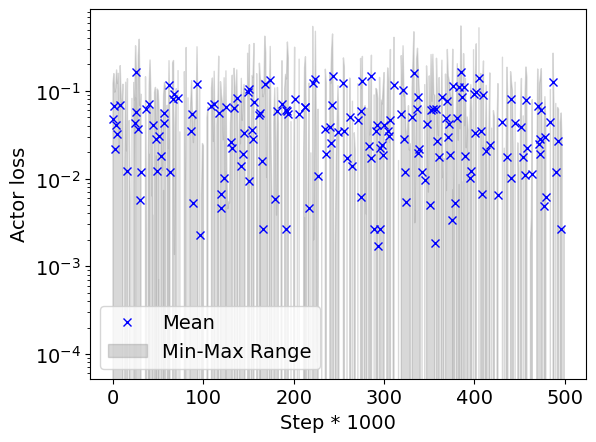

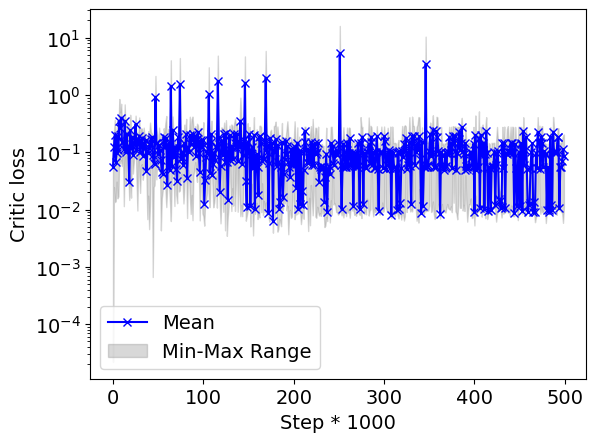

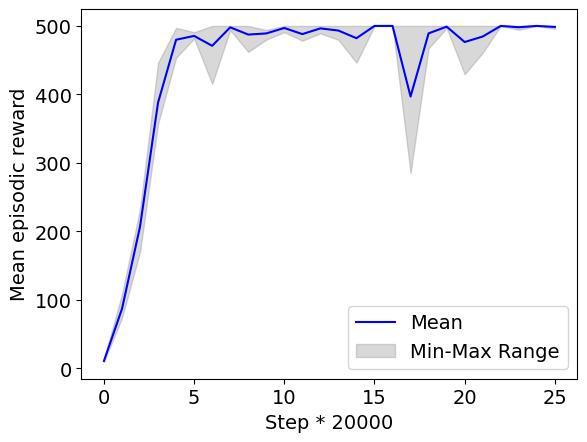

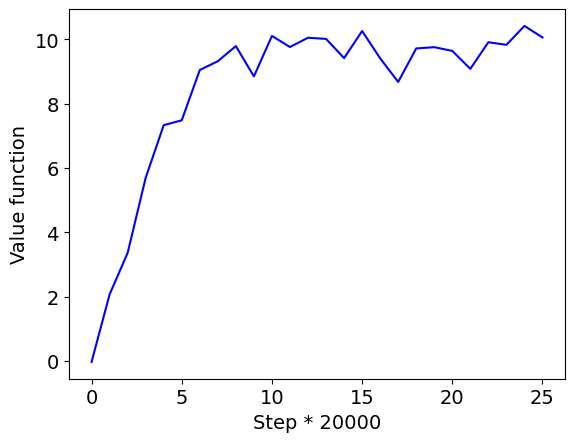

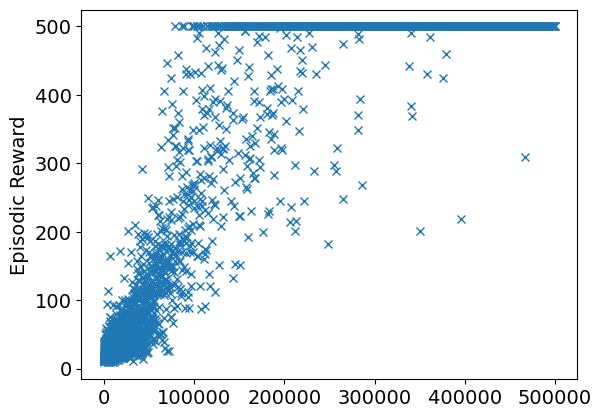

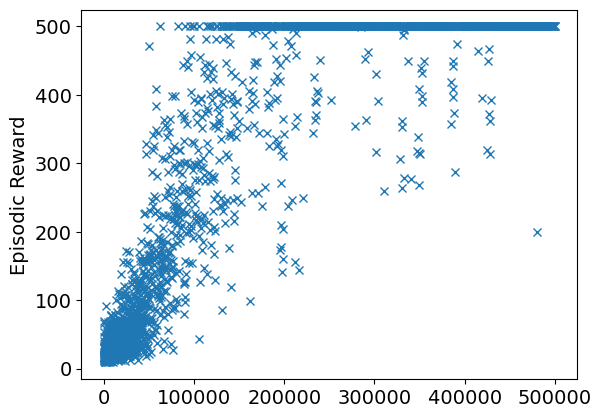

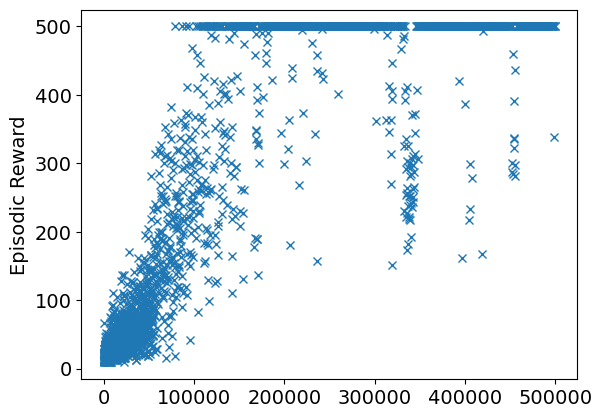

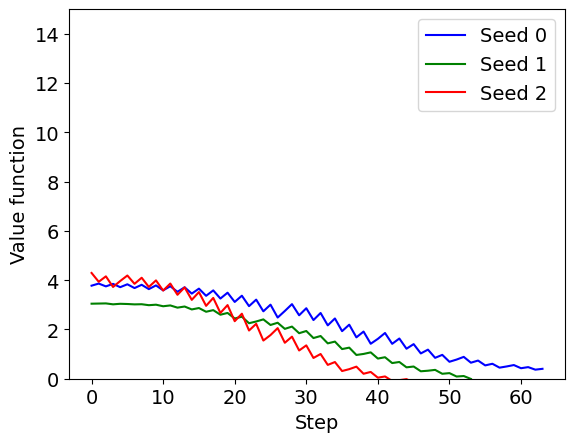

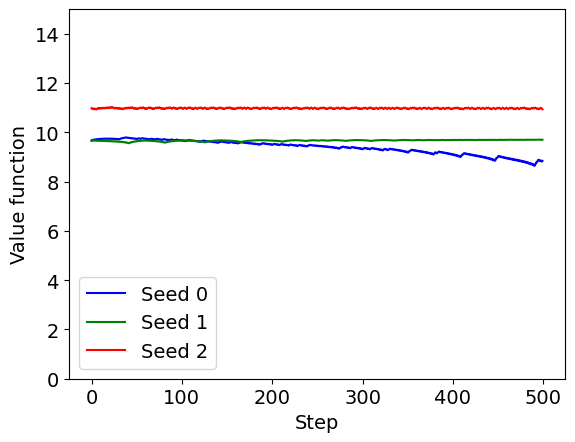

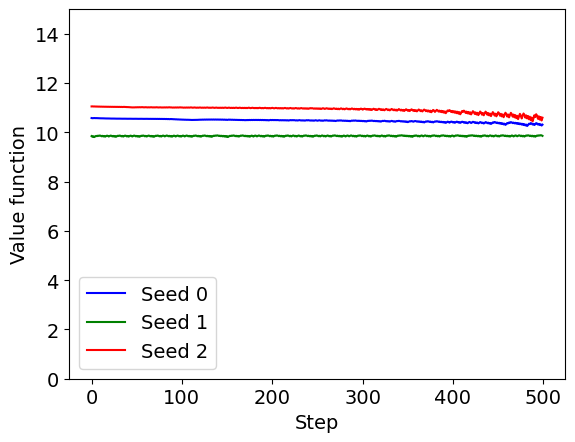

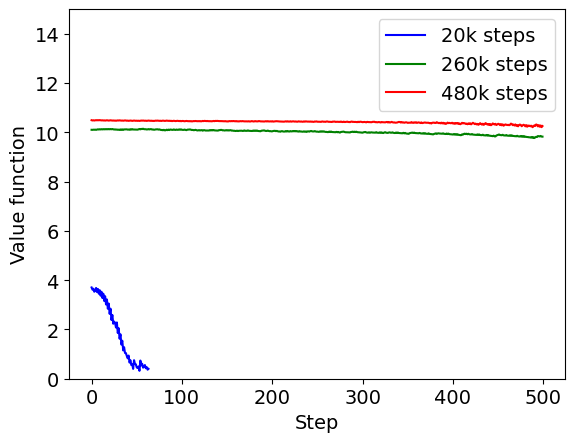

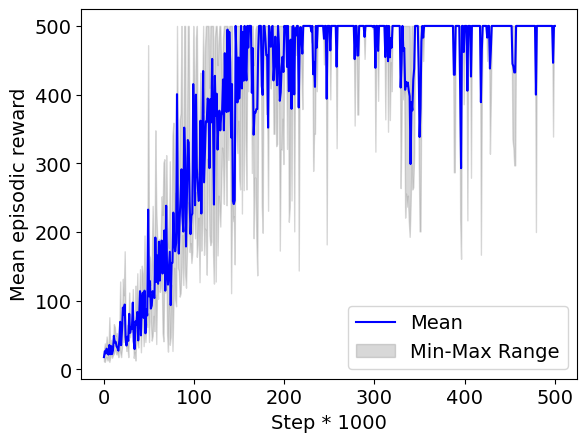

In [16]:
folder_name = 'Results_6env_1step'
plotting(folder_name, seeds)

## Agent 3: 1 env, 6 steps

In [14]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1env_6step'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train_n(seed, filenames, n_envs=1, n_steps=6, sparse=True)

  0%|          | 0/83334 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 12/83334 [00:00<23:12, 59.85it/s]

episodic return of the 20000: 9.3


  4%|▍         | 3342/83334 [01:09<41:14, 32.32it/s]  

episodic return of the 20000: 116.4


  8%|▊         | 6681/83334 [02:06<26:11, 48.77it/s]  

episodic return of the 20000: 131.3


 12%|█▏        | 10011/83334 [02:52<29:23, 41.57it/s]

episodic return of the 20000: 221.6


 16%|█▌        | 13348/83334 [03:37<32:54, 35.45it/s]

episodic return of the 20000: 292.6


 20%|██        | 16673/83334 [04:23<1:04:38, 17.19it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 20011/83334 [05:10<41:15, 25.58it/s]  

episodic return of the 20000: 464.6


 28%|██▊       | 23338/83334 [05:56<42:04, 23.76it/s]

episodic return of the 20000: 475.4


 32%|███▏      | 26671/83334 [06:43<49:26, 19.10it/s]

episodic return of the 20000: 482.9


 36%|███▌      | 30008/83334 [07:31<39:35, 22.45it/s]

episodic return of the 20000: 500.0


 40%|████      | 33338/83334 [08:21<48:00, 17.36it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 36670/83334 [09:11<45:12, 17.21it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 40005/83334 [10:00<34:13, 21.10it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 43336/83334 [10:50<38:44, 17.21it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 46667/83334 [11:46<1:15:39,  8.08it/s]

episodic return of the 20000: 500.0


 60%|██████    | 50007/83334 [12:38<20:09, 27.55it/s]  

episodic return of the 20000: 364.5


 64%|██████▍   | 53333/83334 [13:43<55:55,  8.94it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 56664/83334 [14:54<41:33, 10.70it/s]

episodic return of the 20000: 476.0


 72%|███████▏  | 59995/83334 [15:49<43:57,  8.85it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 63332/83334 [16:45<21:55, 15.20it/s]

episodic return of the 20000: 500.0


 80%|███████▉  | 66663/83334 [17:42<25:07, 11.06it/s]

episodic return of the 20000: 494.2


 84%|████████▍ | 69996/83334 [18:42<13:51, 16.05it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 73330/83334 [19:44<19:17,  8.64it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 76659/83334 [20:44<01:49, 61.10it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 79994/83334 [21:54<07:40,  7.26it/s]

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [22:57<00:00, 60.52it/s]

episodic return of the 20000: 494.8



  0%|          | 5/83334 [00:00<1:10:19, 19.75it/s]

episodic return of the 20000: 12.6


  4%|▍         | 3342/83334 [00:52<33:22, 39.95it/s]

episodic return of the 20000: 105.7


  8%|▊         | 6675/83334 [01:47<30:40, 41.66it/s]  

episodic return of the 20000: 122.3


 12%|█▏        | 10007/83334 [02:40<39:16, 31.12it/s]

episodic return of the 20000: 274.8


 16%|█▌        | 13334/83334 [03:45<1:57:32,  9.93it/s]

episodic return of the 20000: 433.5


 20%|██        | 16670/83334 [04:55<1:19:38, 13.95it/s]

episodic return of the 20000: 355.7


 24%|██▍       | 19998/83334 [05:56<16:45, 62.98it/s]  

episodic return of the 20000: 429.4


 28%|██▊       | 23338/83334 [07:03<3:11:41,  5.22it/s]

episodic return of the 20000: 498.5


 32%|███▏      | 26661/83334 [08:04<14:20, 65.84it/s]  

episodic return of the 20000: 500.0


 36%|███▌      | 29997/83334 [09:06<16:52, 52.68it/s]  

episodic return of the 20000: 500.0


 40%|███▉      | 33327/83334 [10:02<12:54, 64.61it/s]  

episodic return of the 20000: 469.3


 44%|████▍     | 36668/83334 [10:58<56:00, 13.89it/s]  

episodic return of the 20000: 500.0


 48%|████▊     | 40000/83334 [11:59<1:58:21,  6.10it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 43331/83334 [13:03<1:40:58,  6.60it/s]

episodic return of the 20000: 489.3


 56%|█████▌    | 46664/83334 [14:04<1:14:59,  8.15it/s]

episodic return of the 20000: 500.0


 60%|█████▉    | 49998/83334 [15:14<1:30:10,  6.16it/s]

episodic return of the 20000: 500.0


 64%|██████▍   | 53328/83334 [16:19<08:18, 60.21it/s]  

episodic return of the 20000: 500.0


 68%|██████▊   | 56662/83334 [17:22<38:07, 11.66it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 60001/83334 [18:25<1:05:58,  5.89it/s]

episodic return of the 20000: 492.2


 76%|███████▌  | 63341/83334 [19:22<14:41, 22.68it/s]  

episodic return of the 20000: 494.6


 80%|███████▉  | 66665/83334 [20:21<22:11, 12.52it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 70000/83334 [21:19<12:05, 18.37it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 73330/83334 [22:13<08:43, 19.11it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 76667/83334 [23:01<05:50, 19.05it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 80000/83334 [23:48<02:54, 19.15it/s]

episodic return of the 20000: 500.0


100%|█████████▉| 83326/83334 [24:49<00:00,  8.60it/s]

episodic return of the 20000: 488.6


  0%|          | 6/83334 [00:00<44:37, 31.12it/s]  

episodic return of the 20000: 9.3


  4%|▍         | 3340/83334 [01:00<46:28, 28.69it/s]

episodic return of the 20000: 167.2


  8%|▊         | 6675/83334 [01:54<26:05, 48.98it/s]

episodic return of the 20000: 73.3


 12%|█▏        | 10009/83334 [02:53<42:40, 28.63it/s]

episodic return of the 20000: 273.0


 16%|█▌        | 13344/83334 [03:49<47:08, 24.74it/s]  

episodic return of the 20000: 382.2


 20%|█▉        | 16665/83334 [04:42<16:25, 67.66it/s]

episodic return of the 20000: 421.3


 24%|██▍       | 19997/83334 [05:38<16:14, 64.99it/s]  

episodic return of the 20000: 475.5


 28%|██▊       | 23332/83334 [06:34<1:09:19, 14.43it/s]

episodic return of the 20000: 465.8


 32%|███▏      | 26669/83334 [07:38<4:22:42,  3.59it/s]

episodic return of the 20000: 498.7


 36%|███▌      | 30006/83334 [08:35<48:39, 18.27it/s]  

episodic return of the 20000: 500.0


 40%|████      | 33344/83334 [09:30<36:16, 22.97it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 36670/83334 [10:25<41:08, 18.90it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 40006/83334 [11:17<30:11, 23.92it/s]

episodic return of the 20000: 469.4


 52%|█████▏    | 43342/83334 [12:06<29:45, 22.40it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 46670/83334 [12:55<34:44, 17.59it/s]

episodic return of the 20000: 500.0


 60%|█████▉    | 49999/83334 [13:48<33:20, 16.67it/s]

episodic return of the 20000: 500.0


 64%|██████▍   | 53341/83334 [14:39<22:57, 21.78it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 56670/83334 [15:29<19:40, 22.59it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 60007/83334 [16:17<16:46, 23.19it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 63338/83334 [17:09<15:47, 21.10it/s]

episodic return of the 20000: 500.0


 80%|████████  | 66673/83334 [17:59<11:57, 23.23it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 70005/83334 [18:50<10:03, 22.09it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 73342/83334 [19:39<07:09, 23.27it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 76673/83334 [20:31<05:09, 21.51it/s]

episodic return of the 20000: 495.2


 96%|█████████▌| 79999/83334 [21:22<03:09, 17.59it/s]

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [22:13<00:00, 62.48it/s]

episodic return of the 20000: 500.0


[0.0828484605, 2.8435278730379743, 3.140110440425532, 3.79691636105364, 3.2269705615241375, 6.2912751528, 7.0945379196, 8.632074563999998, 7.5079056634, 7.5508711154, 9.149589065, 8.900200963, 9.740916873999998, 9.443864387999998, 9.148959469000001, 7.394640592328042, 9.978372741, 7.84686307176781, 8.619962307000002, 10.433559377000002, 7.1952394649321265, 10.289933164999999, 8.938863139, 9.772976976999999, 10.053989117, 10.591552620999998]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_65423/2077644808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


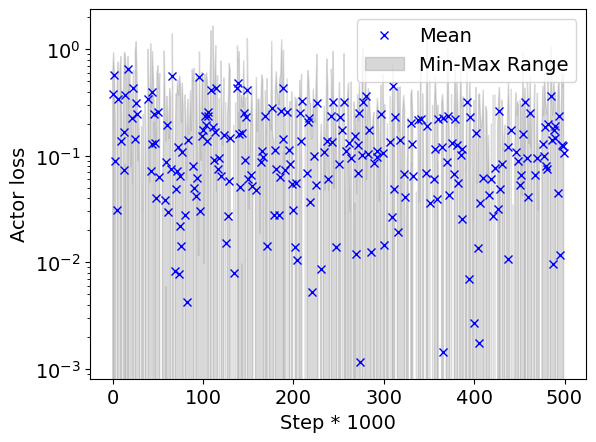

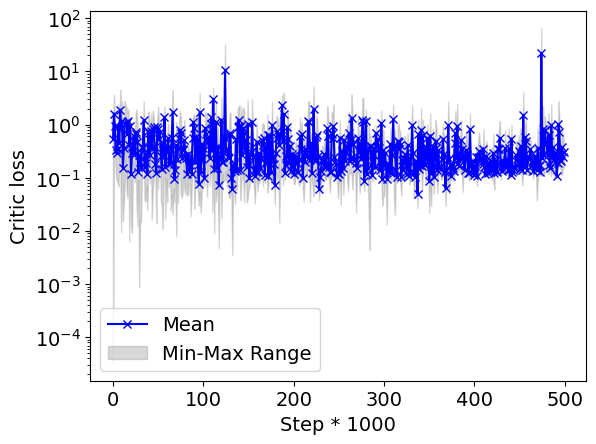

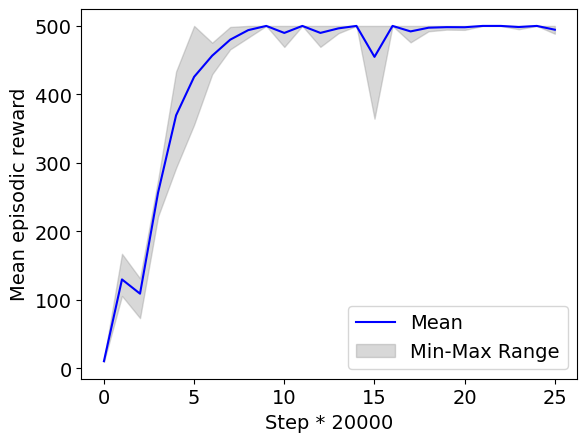

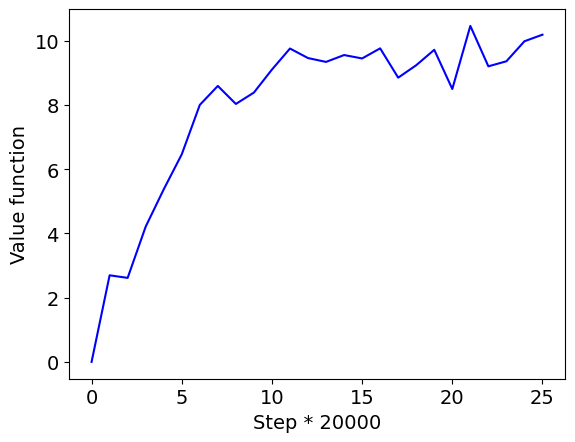

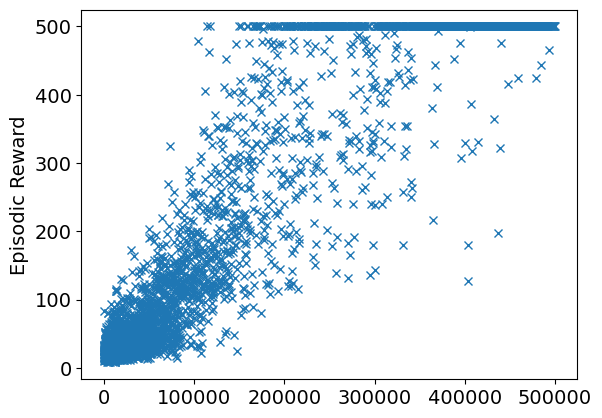

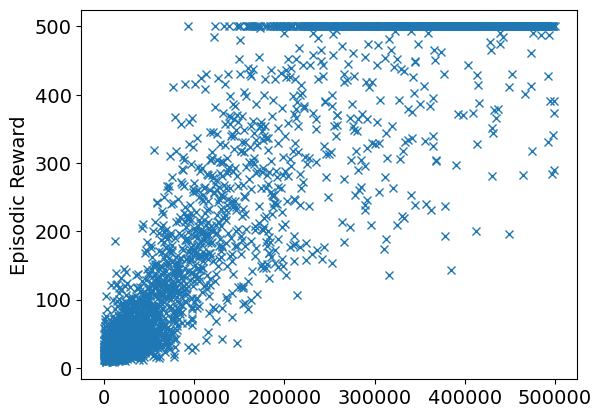

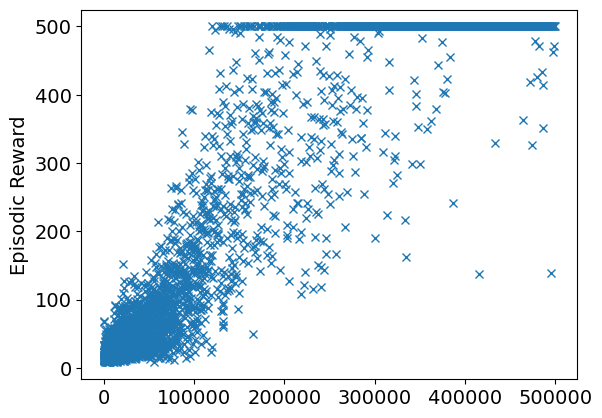

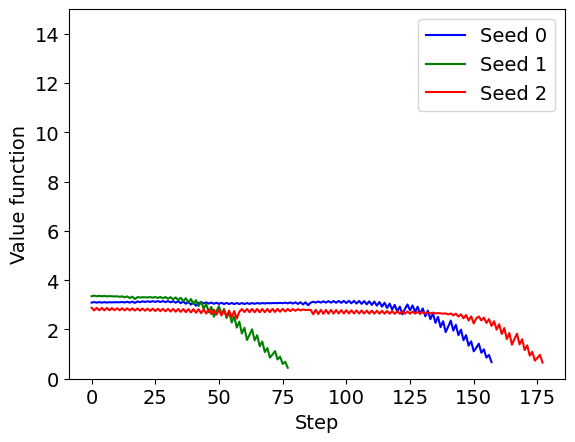

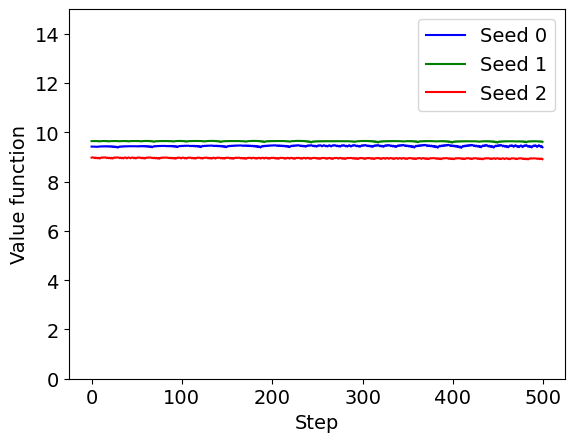

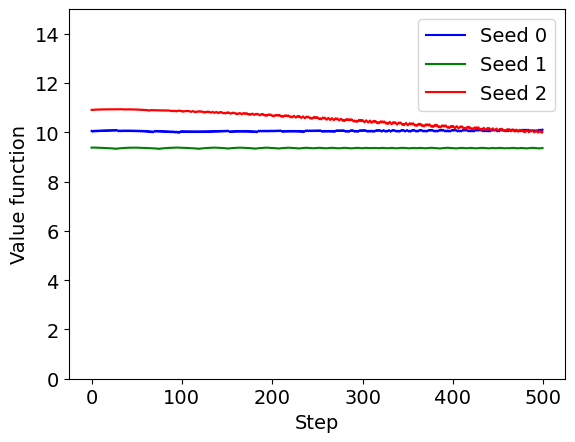

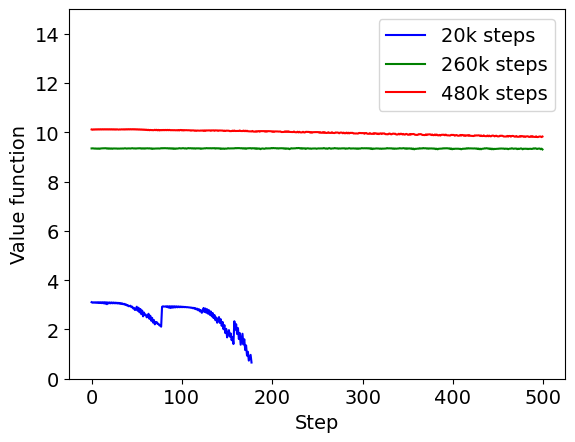

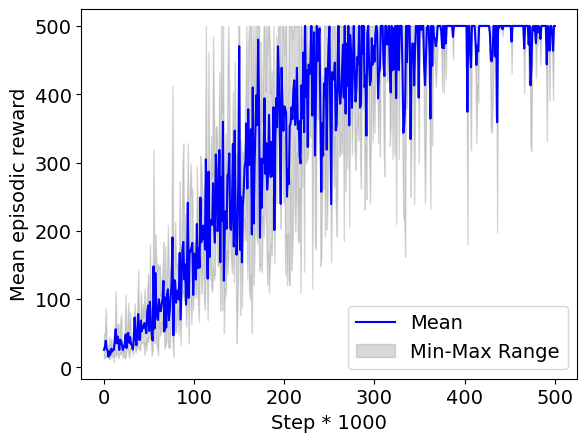

In [15]:
folder_name = 'Results_1env_6step'
plotting(folder_name, seeds)

## Agent 4: 6 env, 6 steps

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_6env_6step'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train_n(seed, filenames, n_envs=6, n_steps=6, sparse=True)

  0%|          | 0/13889 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 5/13889 [00:00<10:07, 22.86it/s]

episodic return of the 20000: 9.4


  4%|▍         | 564/13889 [00:09<03:49, 58.08it/s]

episodic return of the 20000: 36.5


  8%|▊         | 1119/13889 [00:18<06:43, 31.66it/s]

episodic return of the 20000: 124.1


 12%|█▏        | 1678/13889 [00:27<03:35, 56.77it/s]

episodic return of the 20000: 62.3


 16%|█▌        | 2231/13889 [00:35<04:47, 40.58it/s]

episodic return of the 20000: 78.2


 20%|██        | 2792/13889 [00:44<03:33, 51.91it/s]

episodic return of the 20000: 105.1


 24%|██▍       | 3350/13889 [00:52<03:38, 48.26it/s]

episodic return of the 20000: 136.0


 28%|██▊       | 3899/13889 [01:02<04:10, 39.84it/s]

episodic return of the 20000: 195.1


 32%|███▏      | 4458/13889 [01:10<03:53, 40.45it/s]

episodic return of the 20000: 249.2


 36%|███▌      | 5013/13889 [01:19<03:31, 41.91it/s]

episodic return of the 20000: 221.0


 40%|████      | 5572/13889 [01:28<04:00, 34.59it/s]

episodic return of the 20000: 303.3


 44%|████▍     | 6127/13889 [01:37<04:06, 31.51it/s]

episodic return of the 20000: 406.9


 48%|████▊     | 6682/13889 [01:46<04:29, 26.69it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 7240/13889 [01:56<03:58, 27.90it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 7796/13889 [02:04<03:41, 27.48it/s]

episodic return of the 20000: 480.5


 60%|██████    | 8349/13889 [02:14<03:20, 27.58it/s]

episodic return of the 20000: 484.3


 64%|██████▍   | 8908/13889 [02:23<02:52, 28.83it/s]

episodic return of the 20000: 487.0


 68%|██████▊   | 9465/13889 [02:32<02:35, 28.45it/s]

episodic return of the 20000: 496.9


 72%|███████▏  | 10019/13889 [02:41<02:13, 28.97it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 10577/13889 [02:51<01:57, 28.26it/s]

episodic return of the 20000: 500.0


 80%|████████  | 11128/13889 [02:59<02:04, 22.21it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 11683/13889 [03:09<01:37, 22.70it/s]

episodic return of the 20000: 488.5


 88%|████████▊ | 12241/13889 [03:17<00:58, 28.04it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 12798/13889 [03:27<00:41, 26.50it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 13353/13889 [03:35<00:18, 28.91it/s]

episodic return of the 20000: 500.0


  0%|          | 4/13889 [00:00<14:06, 16.40it/s]

episodic return of the 20000: 12.2


  4%|▍         | 570/13889 [00:09<03:55, 56.58it/s]

episodic return of the 20000: 58.2


  8%|▊         | 1126/13889 [00:18<04:16, 49.70it/s]

episodic return of the 20000: 111.3


 12%|█▏        | 1680/13889 [00:27<03:46, 53.97it/s]

episodic return of the 20000: 87.8


 16%|█▌        | 2232/13889 [00:36<04:04, 47.68it/s]

episodic return of the 20000: 139.6


 20%|██        | 2788/13889 [00:45<04:21, 42.38it/s]

episodic return of the 20000: 180.5


 24%|██▍       | 3348/13889 [00:54<04:12, 41.71it/s]

episodic return of the 20000: 198.4


 28%|██▊       | 3903/13889 [01:03<04:11, 39.78it/s]

episodic return of the 20000: 230.7


 32%|███▏      | 4463/13889 [01:12<04:31, 34.67it/s]

episodic return of the 20000: 321.1


 36%|███▌      | 5016/13889 [01:21<05:33, 26.64it/s]

episodic return of the 20000: 404.5


 40%|████      | 5572/13889 [01:30<04:24, 31.48it/s]

episodic return of the 20000: 422.8


 44%|████▍     | 6126/13889 [01:40<04:16, 30.24it/s]

episodic return of the 20000: 364.7


 48%|████▊     | 6681/13889 [01:49<03:40, 32.69it/s]

episodic return of the 20000: 392.6


 52%|█████▏    | 7240/13889 [01:58<05:47, 19.11it/s]

episodic return of the 20000: 481.2


 56%|█████▌    | 7797/13889 [02:07<03:24, 29.77it/s]

episodic return of the 20000: 469.5


 60%|██████    | 8353/13889 [02:17<03:36, 25.61it/s]

episodic return of the 20000: 462.6


 64%|██████▍   | 8908/13889 [02:26<03:21, 24.71it/s]

episodic return of the 20000: 487.7


 68%|██████▊   | 9463/13889 [02:36<03:08, 23.53it/s]

episodic return of the 20000: 475.7


 72%|███████▏  | 10022/13889 [02:45<02:26, 26.43it/s]

episodic return of the 20000: 464.7


 76%|███████▌  | 10576/13889 [02:55<02:16, 24.35it/s]

episodic return of the 20000: 465.9


 80%|████████  | 11128/13889 [03:04<01:49, 25.18it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 11686/13889 [03:13<01:21, 26.92it/s]

episodic return of the 20000: 499.3


 88%|████████▊ | 12243/13889 [03:23<01:05, 24.99it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 12796/13889 [03:32<00:41, 26.47it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 13354/13889 [03:42<00:20, 26.23it/s]

episodic return of the 20000: 500.0


  0%|          | 4/13889 [00:00<12:24, 18.66it/s]

episodic return of the 20000: 9.3


  4%|▍         | 564/13889 [00:09<03:49, 57.96it/s]

episodic return of the 20000: 34.6


  8%|▊         | 1124/13889 [00:18<05:48, 36.63it/s]

episodic return of the 20000: 234.9


 12%|█▏        | 1677/13889 [00:28<04:38, 43.91it/s]

episodic return of the 20000: 140.3


 16%|█▌        | 2237/13889 [00:37<05:34, 34.79it/s]

episodic return of the 20000: 268.3


 20%|██        | 2789/13889 [00:47<04:27, 41.43it/s]

episodic return of the 20000: 164.8


 24%|██▍       | 3350/13889 [00:56<05:05, 34.45it/s]

episodic return of the 20000: 271.5


 28%|██▊       | 3905/13889 [01:06<05:05, 32.68it/s]

episodic return of the 20000: 274.4


 32%|███▏      | 4459/13889 [01:14<04:27, 35.22it/s]

episodic return of the 20000: 258.3


 36%|███▌      | 5016/13889 [01:24<04:45, 31.12it/s]

episodic return of the 20000: 339.3


 40%|████      | 5571/13889 [01:33<04:28, 30.93it/s]

episodic return of the 20000: 354.9


 44%|████▍     | 6124/13889 [01:43<04:48, 26.95it/s]

episodic return of the 20000: 466.6


 48%|████▊     | 6682/13889 [01:52<04:32, 26.41it/s]

episodic return of the 20000: 466.0


 52%|█████▏    | 7238/13889 [02:02<04:13, 26.21it/s]

episodic return of the 20000: 468.6


 56%|█████▌    | 7796/13889 [02:11<03:57, 25.68it/s]

episodic return of the 20000: 489.8


 60%|██████    | 8348/13889 [02:21<03:32, 26.03it/s]

episodic return of the 20000: 471.2


 64%|██████▍   | 8907/13889 [02:30<03:19, 24.92it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 9460/13889 [02:40<02:42, 27.25it/s]

episodic return of the 20000: 445.8


 72%|███████▏  | 10019/13889 [02:49<02:31, 25.60it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 10575/13889 [02:59<02:08, 25.75it/s]

episodic return of the 20000: 486.0


 80%|████████  | 11129/13889 [03:08<01:52, 24.57it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 11688/13889 [03:18<01:55, 19.02it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 12244/13889 [03:27<01:10, 23.41it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 12798/13889 [03:37<00:46, 23.26it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 13352/13889 [03:46<00:28, 19.07it/s]

episodic return of the 20000: 483.0


100%|██████████| 13889/13889 [03:55<00:00, 59.09it/s]


[0.1275380931111111, 1.8860957125, 2.59973238989899, 2.082034083, 1.4489862699142857, 2.371063897070707, 3.873232563716814, 4.106981447619048, 3.5308057494849785, 2.5964589946411487, 4.436813741881188, 3.58718999747191, 5.1814406008, 6.6736676354, 5.882185160952381, 7.615569744, 8.077369672, 7.0486072462000005, 7.0129950274, 8.606378518000001, 8.526422485, 9.213297136, 8.585489997, 9.069101296000001, 9.176449024]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_68473/2077644808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


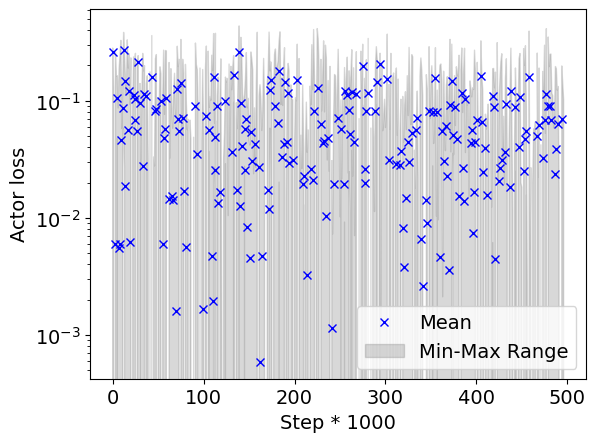

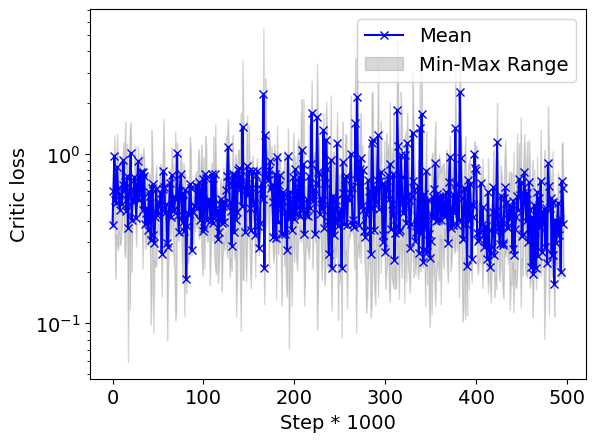

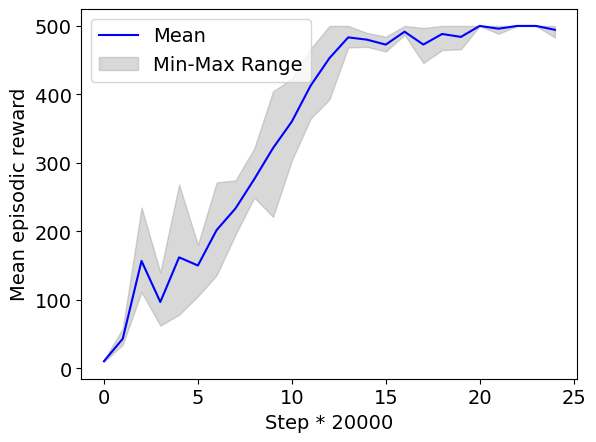

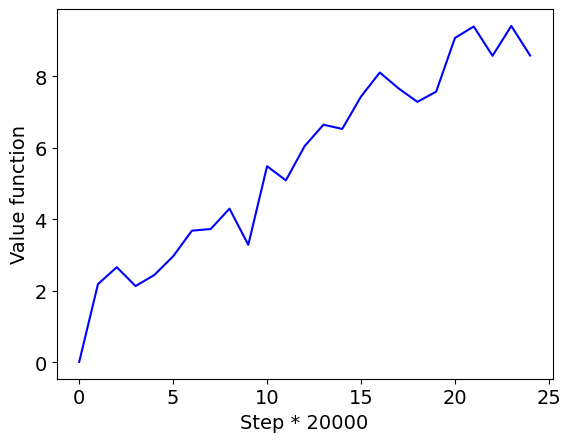

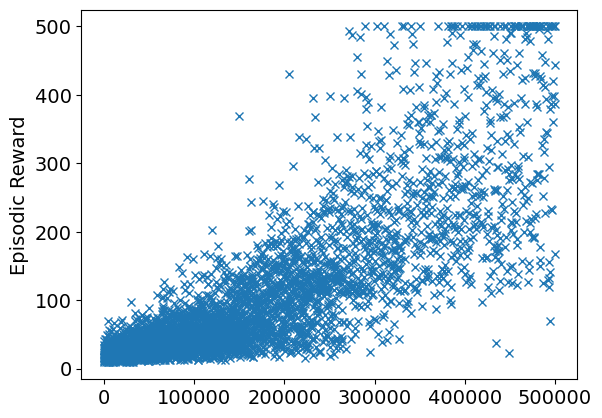

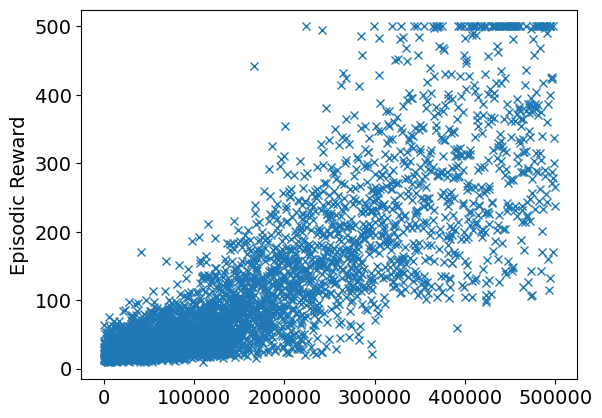

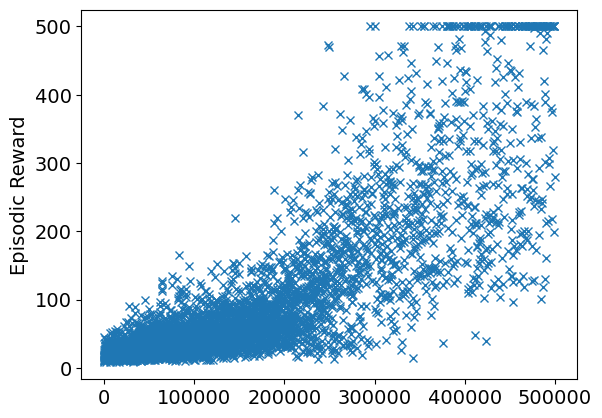

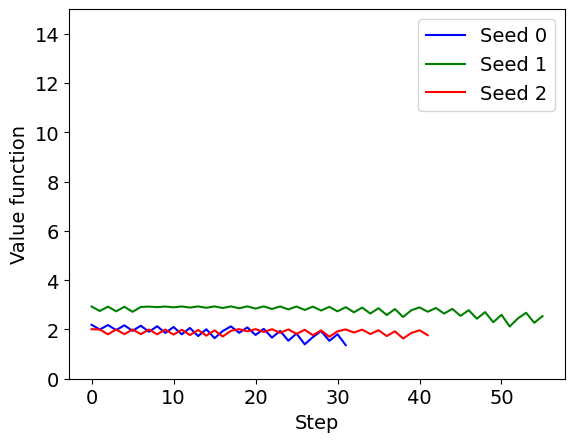

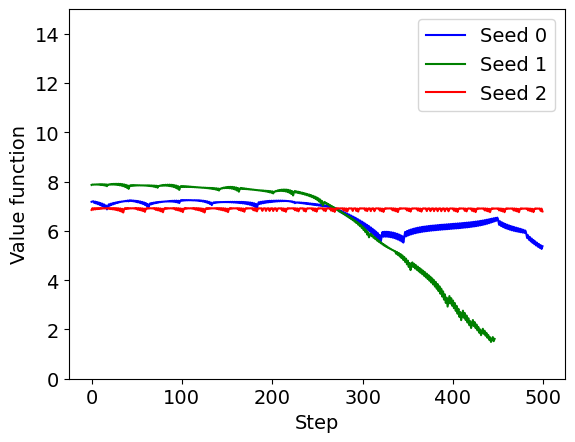

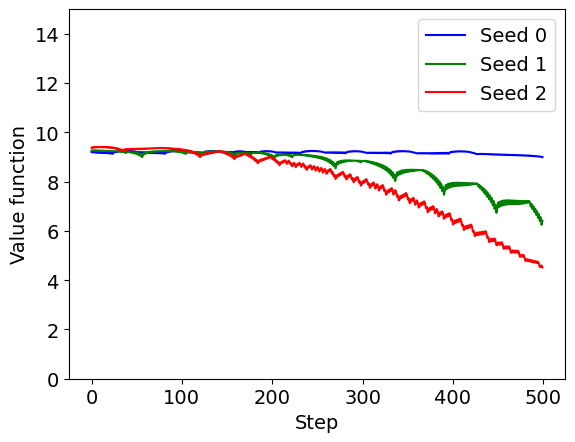

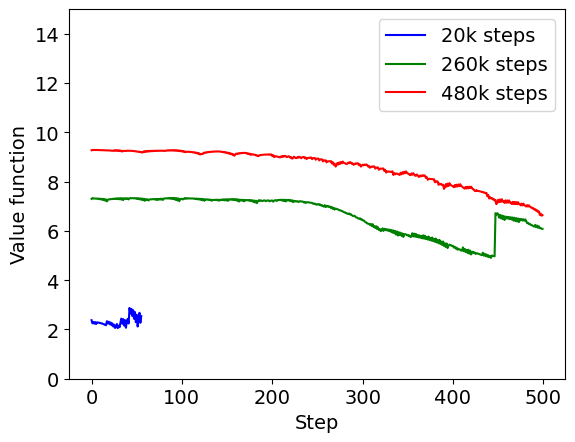

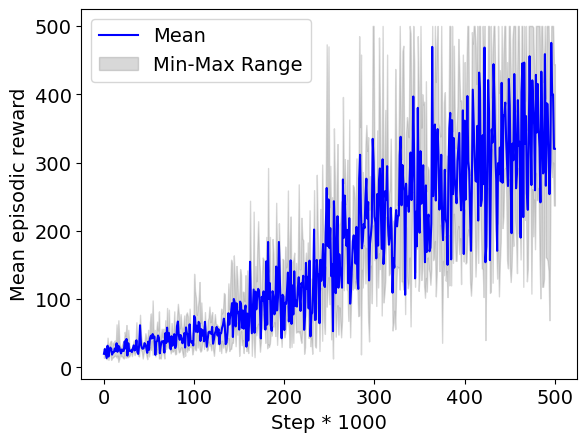

In [12]:
folder_name = 'Results_6env_6step'
plotting(folder_name, seeds)

## Agent 5: 1 env, 1 step, continuous

In [23]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1env_1step_cont'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=True, continuous=True)

  0%|          | 29/500000 [00:00<51:48, 160.85it/s]

episodic return of the 20000: 14.1


  4%|▍         | 20037/500000 [01:40<1:00:09, 132.96it/s]

episodic return of the 20000: 113.0


  8%|▊         | 40046/500000 [03:09<1:25:48, 89.34it/s] 

episodic return of the 20000: 324.6


 12%|█▏        | 60038/500000 [04:43<1:08:57, 106.34it/s]

episodic return of the 20000: 214.4


 16%|█▌        | 80010/500000 [06:13<2:05:30, 55.77it/s] 

episodic return of the 20000: 399.5


 20%|██        | 100032/500000 [07:48<4:01:08, 27.64it/s]

episodic return of the 20000: 915.7


 24%|██▍       | 120046/500000 [09:23<4:04:26, 25.91it/s] 

episodic return of the 20000: 1000.0


 28%|██▊       | 140039/500000 [11:04<4:00:23, 24.96it/s] 

episodic return of the 20000: 1000.0


 32%|███▏      | 160026/500000 [12:42<3:35:51, 26.25it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 180029/500000 [14:20<3:22:18, 26.36it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200043/500000 [16:00<3:22:16, 24.72it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 220032/500000 [17:39<3:01:07, 25.76it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 240041/500000 [19:20<3:12:00, 22.56it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 260022/500000 [21:28<4:40:50, 14.24it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 280037/500000 [23:05<2:00:14, 30.49it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 300005/500000 [24:42<5:44:02,  9.69it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 320038/500000 [26:13<1:48:33, 27.63it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340033/500000 [27:40<1:39:30, 26.79it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 360040/500000 [29:12<1:26:30, 26.97it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 380017/500000 [30:43<1:19:53, 25.03it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 400032/500000 [32:18<58:26, 28.51it/s]  

episodic return of the 20000: 1000.0


 84%|████████▍ | 420037/500000 [33:50<46:09, 28.87it/s]  

episodic return of the 20000: 1000.0


 88%|████████▊ | 440033/500000 [35:22<38:32, 25.93it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460024/500000 [37:06<23:04, 28.88it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480036/500000 [39:07<13:28, 24.70it/s] 

episodic return of the 20000: 1000.0


  0%|          | 19/500000 [00:00<1:24:42, 98.38it/s]

episodic return of the 20000: 8.4


  4%|▍         | 20025/500000 [01:46<56:01, 142.80it/s]  

episodic return of the 20000: 69.0


  8%|▊         | 39989/500000 [03:28<31:35, 242.65it/s]  

episodic return of the 20000: 607.4


 12%|█▏        | 60020/500000 [05:18<5:49:19, 20.99it/s] 

episodic return of the 20000: 602.8


 16%|█▌        | 80036/500000 [07:00<1:25:15, 82.09it/s] 

episodic return of the 20000: 255.8


 20%|██        | 100021/500000 [08:46<4:30:55, 24.61it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 120032/500000 [10:32<3:37:42, 29.09it/s] 

episodic return of the 20000: 1000.0


 28%|██▊       | 140028/500000 [12:23<4:35:22, 21.79it/s] 

episodic return of the 20000: 1000.0


 32%|███▏      | 160035/500000 [14:06<4:19:30, 21.83it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 180031/500000 [15:53<3:57:31, 22.45it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200030/500000 [17:41<3:49:11, 21.81it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 220018/500000 [19:28<3:26:28, 22.60it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 240023/500000 [21:14<4:11:56, 17.20it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 260035/500000 [23:01<3:08:33, 21.21it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 280031/500000 [24:49<2:36:11, 23.47it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 300024/500000 [26:38<3:18:11, 16.82it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 320040/500000 [28:29<2:22:49, 21.00it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340024/500000 [30:15<1:54:30, 23.29it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 360040/500000 [32:06<1:41:43, 22.93it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 380028/500000 [34:02<1:11:29, 27.97it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 400026/500000 [35:35<56:21, 29.56it/s]  

episodic return of the 20000: 1000.0


 84%|████████▍ | 420041/500000 [37:07<44:55, 29.66it/s]  

episodic return of the 20000: 1000.0


 88%|████████▊ | 440025/500000 [38:39<46:50, 21.34it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460038/500000 [40:12<22:23, 29.73it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480031/500000 [41:46<13:13, 25.16it/s] 

episodic return of the 20000: 1000.0


  0%|          | 29/500000 [00:00<54:10, 153.80it/s]

episodic return of the 20000: 13.9


  4%|▍         | 20048/500000 [01:37<51:17, 155.93it/s]  

episodic return of the 20000: 82.0


  8%|▊         | 40030/500000 [03:10<1:01:33, 124.55it/s]

episodic return of the 20000: 142.4


 12%|█▏        | 60033/500000 [04:47<1:09:01, 106.22it/s]

episodic return of the 20000: 207.9


 16%|█▌        | 80025/500000 [06:21<1:07:10, 104.20it/s]

episodic return of the 20000: 182.6


 20%|██        | 100027/500000 [07:57<1:23:47, 79.55it/s]

episodic return of the 20000: 318.9


 24%|██▍       | 119999/500000 [09:33<28:24, 222.93it/s]  

episodic return of the 20000: 490.8


 28%|██▊       | 140039/500000 [11:19<3:54:24, 25.59it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 160040/500000 [13:01<3:57:27, 23.86it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 180026/500000 [14:37<2:59:16, 29.75it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200026/500000 [16:03<3:31:24, 23.65it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 220025/500000 [17:26<2:32:18, 30.64it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 240029/500000 [18:52<2:18:47, 31.22it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 260031/500000 [20:17<1:53:08, 35.35it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 280020/500000 [21:41<1:44:36, 35.05it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 300034/500000 [23:06<1:22:44, 40.28it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 320039/500000 [24:30<1:30:11, 33.26it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340045/500000 [25:55<1:23:24, 31.96it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 360053/500000 [27:18<56:05, 41.59it/s]  

episodic return of the 20000: 1000.0


 76%|███████▌  | 380031/500000 [28:43<59:47, 33.44it/s]  

episodic return of the 20000: 1000.0


 80%|████████  | 400031/500000 [30:08<51:06, 32.60it/s]  

episodic return of the 20000: 1000.0


 84%|████████▍ | 420031/500000 [31:33<40:44, 32.72it/s] 

episodic return of the 20000: 1000.0


 88%|████████▊ | 440044/500000 [32:58<31:19, 31.90it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460051/500000 [34:21<20:22, 32.67it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480048/500000 [35:46<09:57, 33.38it/s] 

episodic return of the 20000: 1000.0


100%|██████████| 500000/500000 [37:07<00:00, 224.46it/s]


[-0.076372850375, 1.694300380413223, 2.898082659724242, 3.601878822201835, 2.9197217241186872, 6.298704560322581, 4.903844111000001, 8.442795353, 9.821256169, 9.340213531000002, 9.6175843295, 11.829042827500002, 8.9337266675, 9.2545245695, 10.460458054499998, 10.344353161999999, 10.260821237, 8.312072761, 8.728138052, 11.3326721635, 9.47149612, 8.9463142585, 11.097322451499997, 9.8681630045, 10.138649328999998]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_55758/886802808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


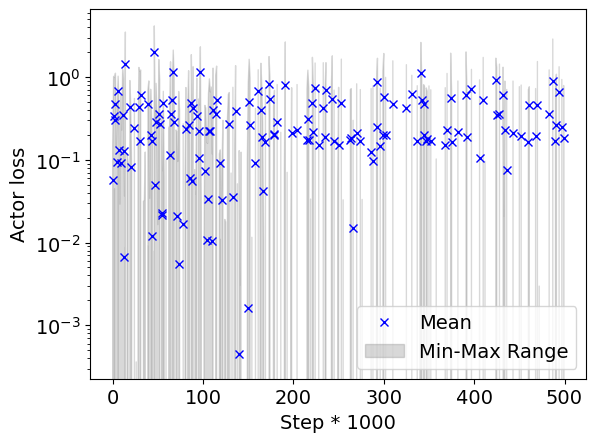

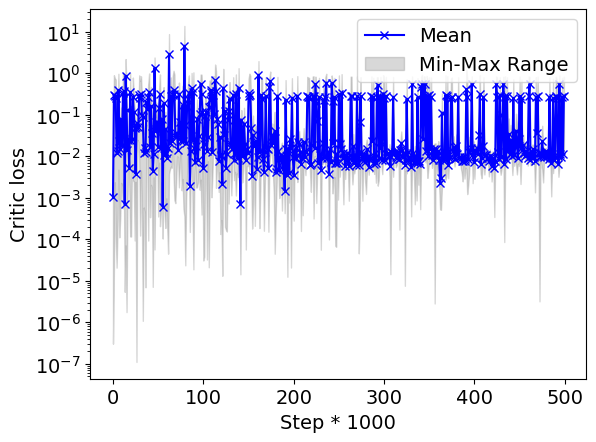

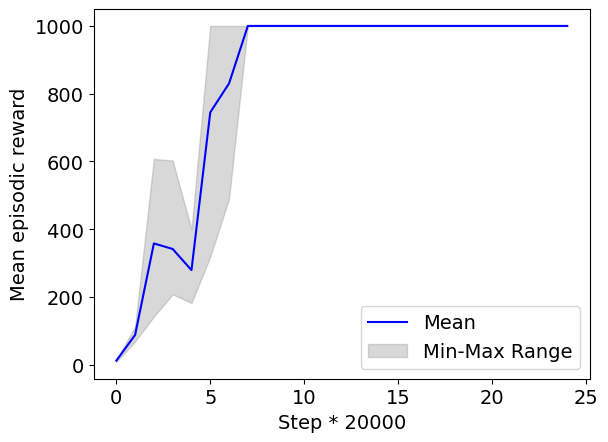

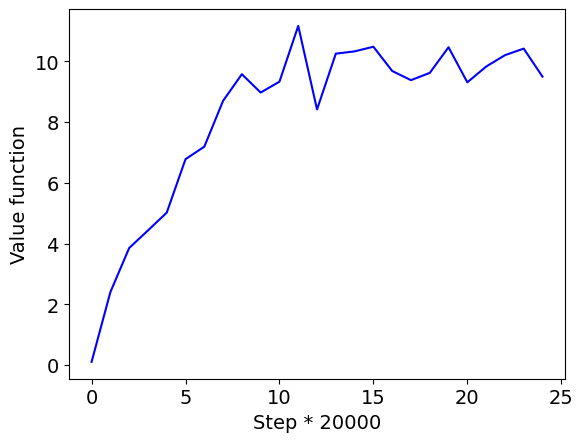

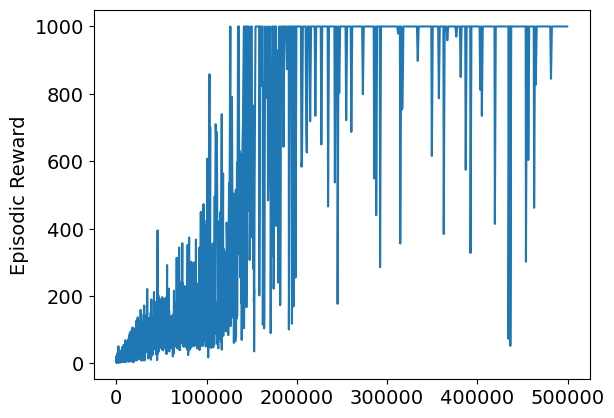

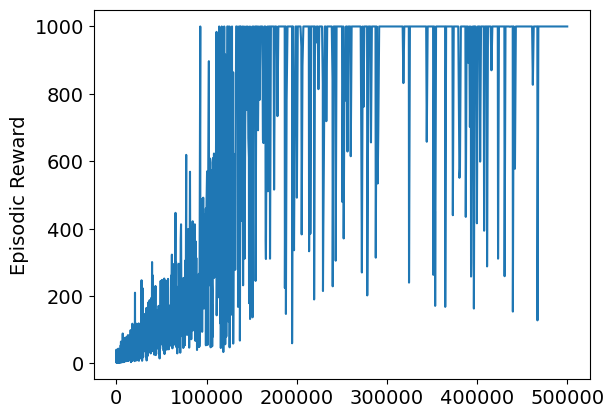

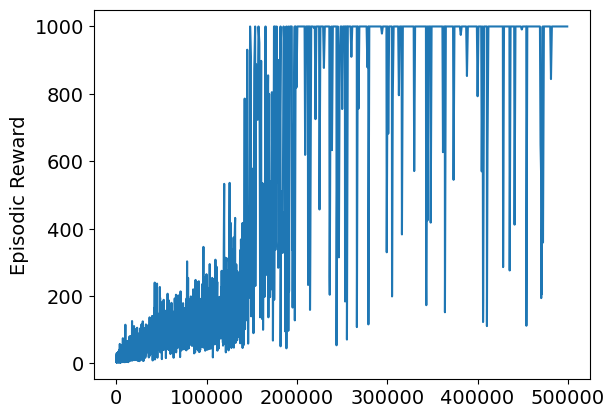

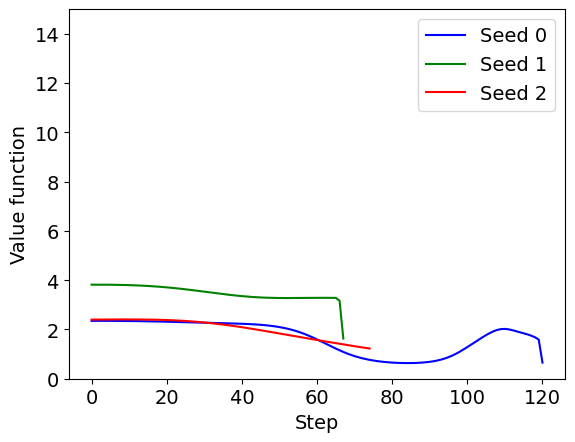

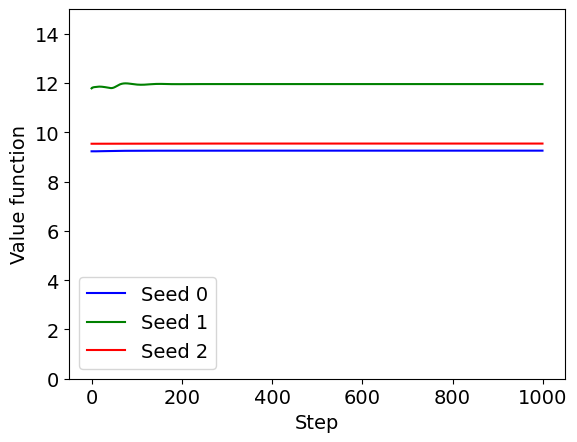

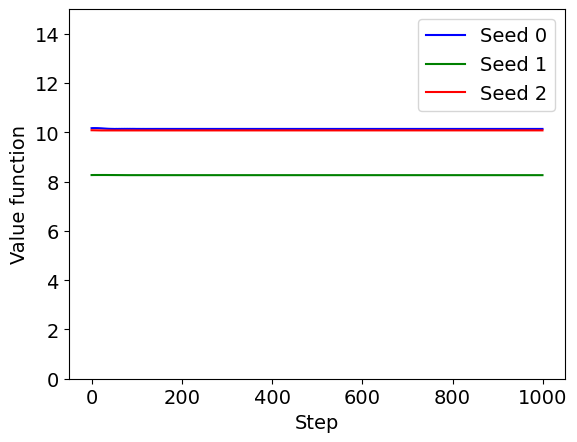

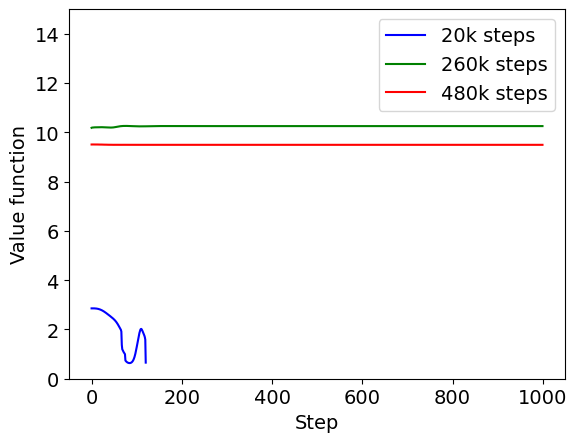

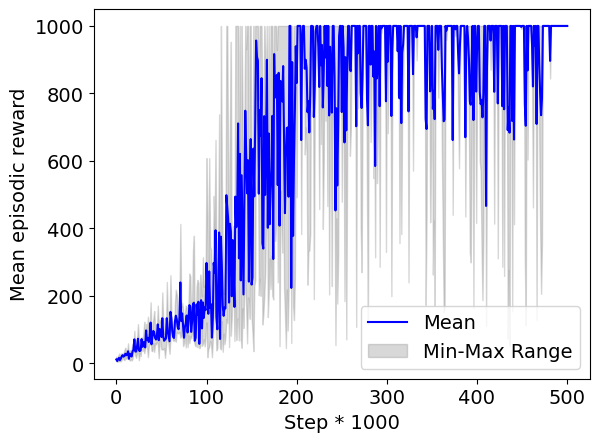

In [101]:
folder_name = 'Results_1env_1step_cont'
plotting(folder_name, seeds)

## Agent 6: 6 envs, 6 steps, continuous

In [12]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_6env_6step_cont'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train_n(seed, filenames, n_envs=6, n_steps=6, sparse=True, continuous=True, lr_actor=3e-4)

  0%|          | 5/13889 [00:00<10:19, 22.40it/s]

episodic return of the 20000: 13.5


  4%|▍         | 561/13889 [00:15<26:51,  8.27it/s]

episodic return of the 20000: 176.7


  8%|▊         | 1123/13889 [00:27<09:32, 22.31it/s]

episodic return of the 20000: 252.8


 12%|█▏        | 1673/13889 [00:43<43:10,  4.71it/s]

episodic return of the 20000: 1000.0


 16%|█▌        | 2231/13889 [00:59<43:01,  4.52it/s]

episodic return of the 20000: 1000.0


 20%|██        | 2788/13889 [01:17<27:46,  6.66it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 3341/13889 [01:36<53:08,  3.31it/s]

episodic return of the 20000: 1000.0


 28%|██▊       | 3903/13889 [01:52<27:03,  6.15it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 4454/13889 [02:07<26:40,  5.90it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5011/13889 [02:23<27:31,  5.38it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5567/13889 [02:38<26:35,  5.22it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 6123/13889 [02:54<25:27,  5.08it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6677/13889 [03:09<26:11,  4.59it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7237/13889 [03:26<29:41,  3.73it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7790/13889 [03:41<18:55,  5.37it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 8351/13889 [03:57<15:15,  6.05it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8906/13889 [04:12<12:50,  6.47it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9459/13889 [04:28<13:06,  5.63it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10016/13889 [04:43<12:51,  5.02it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10571/13889 [04:59<11:52,  4.66it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11127/13889 [05:16<08:34,  5.37it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11683/13889 [05:36<05:28,  6.72it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12237/13889 [05:52<05:18,  5.18it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12794/13889 [06:06<03:37,  5.03it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13350/13889 [06:21<01:28,  6.11it/s]

episodic return of the 20000: 1000.0


  0%|          | 6/13889 [00:00<07:53, 29.35it/s]

episodic return of the 20000: 8.6


  4%|▍         | 563/13889 [00:11<06:38, 33.48it/s]

episodic return of the 20000: 104.6


  8%|▊         | 1114/13889 [00:26<30:02,  7.09it/s]

episodic return of the 20000: 497.5


 12%|█▏        | 1674/13889 [00:41<42:38,  4.77it/s]

episodic return of the 20000: 1000.0


 16%|█▌        | 2229/13889 [00:55<39:59,  4.86it/s]

episodic return of the 20000: 1000.0


 20%|██        | 2784/13889 [01:16<1:19:40,  2.32it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 3342/13889 [01:32<26:57,  6.52it/s]  

episodic return of the 20000: 1000.0


 28%|██▊       | 3901/13889 [01:46<25:41,  6.48it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 4454/13889 [02:01<31:37,  4.97it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5015/13889 [02:15<23:00,  6.43it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5569/13889 [02:30<21:58,  6.31it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 6121/13889 [02:44<25:10,  5.14it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6677/13889 [02:58<19:08,  6.28it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7235/13889 [03:14<17:50,  6.22it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7792/13889 [03:29<15:20,  6.62it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 8345/13889 [03:43<17:22,  5.32it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8903/13889 [03:58<13:25,  6.19it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9462/13889 [04:12<10:48,  6.83it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10014/13889 [04:28<15:14,  4.24it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10570/13889 [04:42<11:14,  4.92it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11130/13889 [04:59<06:53,  6.67it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11682/13889 [05:14<06:16,  5.86it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12238/13889 [05:28<05:34,  4.93it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12789/13889 [05:48<08:29,  2.16it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13349/13889 [06:09<02:27,  3.67it/s]

episodic return of the 20000: 1000.0


  0%|          | 3/13889 [00:00<16:07, 14.35it/s]

episodic return of the 20000: 15.7


  4%|▍         | 565/13889 [00:11<06:56, 32.02it/s]

episodic return of the 20000: 135.3


  8%|▊         | 1118/13889 [00:25<07:33, 28.13it/s]

episodic return of the 20000: 79.0


 12%|█▏        | 1674/13889 [00:41<11:56, 17.04it/s]

episodic return of the 20000: 267.4


 16%|█▌        | 2230/13889 [01:01<56:40,  3.43it/s]  

episodic return of the 20000: 1000.0


 20%|██        | 2787/13889 [01:18<48:34,  3.81it/s]  

episodic return of the 20000: 1000.0


 24%|██▍       | 3342/13889 [01:39<46:40,  3.77it/s]  

episodic return of the 20000: 1000.0


 28%|██▊       | 3898/13889 [01:56<32:07,  5.18it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 4457/13889 [02:14<40:07,  3.92it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5012/13889 [02:34<50:04,  2.96it/s]  

episodic return of the 20000: 1000.0


 40%|████      | 5566/13889 [02:57<53:17,  2.60it/s]  

episodic return of the 20000: 1000.0


 44%|████▍     | 6122/13889 [03:18<38:33,  3.36it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6680/13889 [03:39<39:42,  3.03it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7231/13889 [04:06<1:26:46,  1.28it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7791/13889 [04:27<24:41,  4.12it/s]  

episodic return of the 20000: 1000.0


 60%|██████    | 8345/13889 [04:48<27:53,  3.31it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8906/13889 [05:10<17:57,  4.62it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9461/13889 [05:25<11:26,  6.45it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10014/13889 [05:44<16:41,  3.87it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10571/13889 [06:00<09:33,  5.78it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11129/13889 [06:14<07:03,  6.52it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11685/13889 [06:29<06:33,  5.60it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12240/13889 [06:45<04:56,  5.56it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12797/13889 [07:02<03:11,  5.69it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13350/13889 [07:18<01:35,  5.66it/s]

episodic return of the 20000: 1000.0


100%|██████████| 13889/13889 [07:30<00:00, 30.82it/s]


[-0.079529505, 4.699253032624113, 4.791533403874539, 7.4565369907, 9.401265905, 9.293196251499998, 10.194235013000002, 10.338571395, 9.114266851999998, 9.820172986500001, 9.215283542500002, 10.9878423785, 10.381800052, 10.086537804499999, 10.167429569, 9.832189678499999, 9.3935082245, 9.2912756355, 9.246943704000001, 9.508645670999998, 9.662420162999998, 10.054898856, 10.214700668499999, 9.584342756500002, 10.151202880500001]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_65423/2077644808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


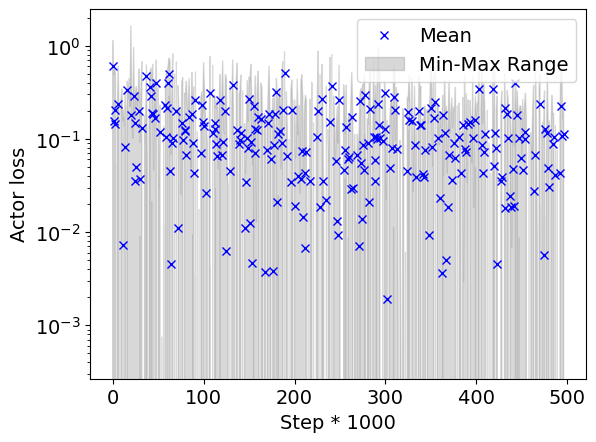

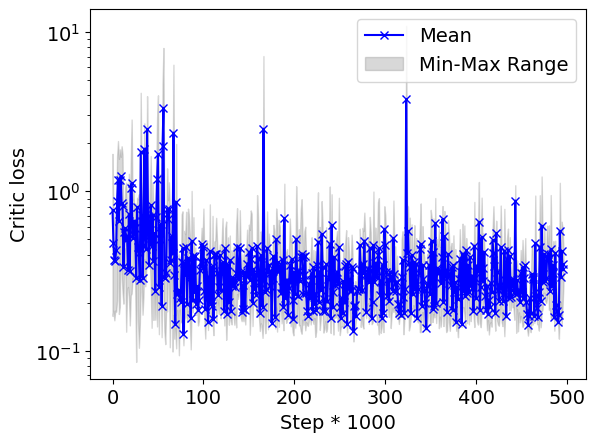

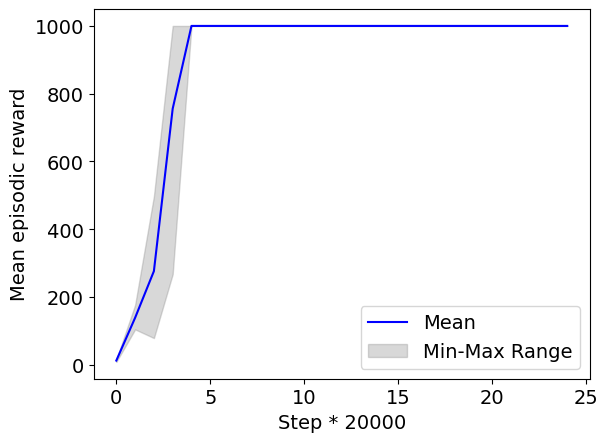

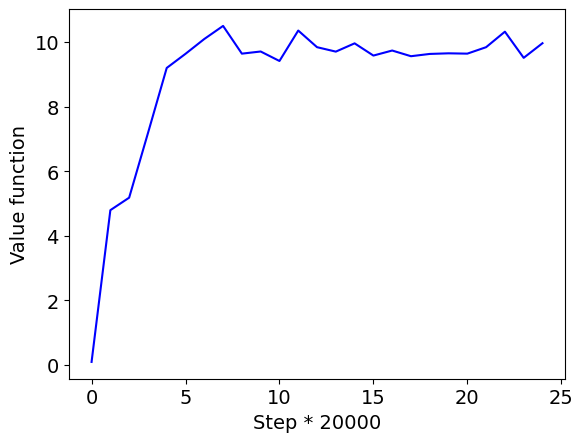

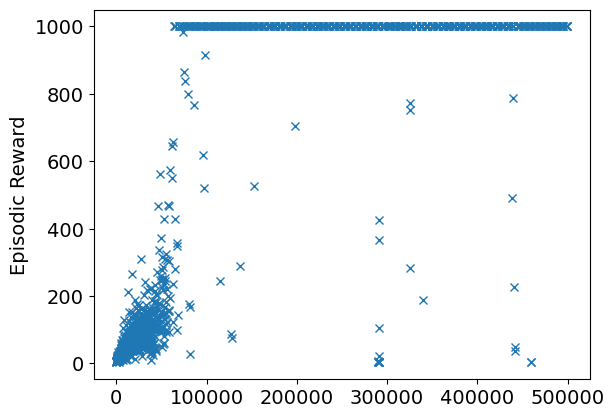

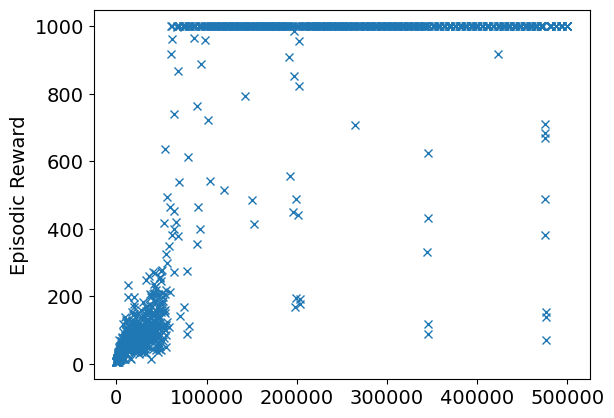

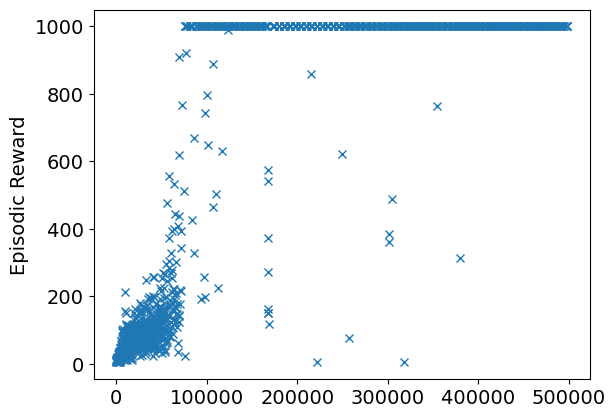

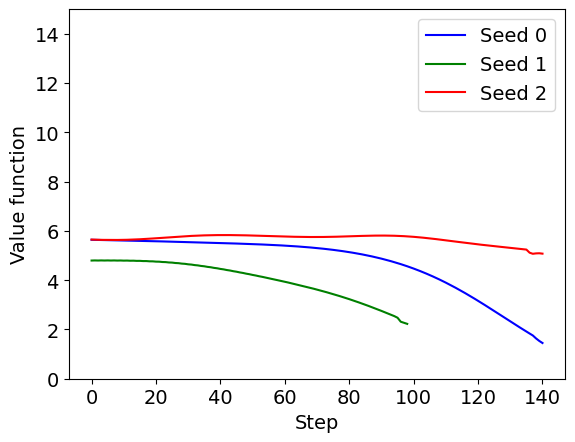

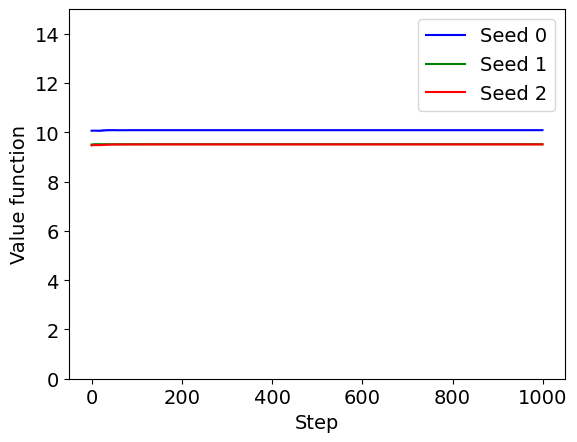

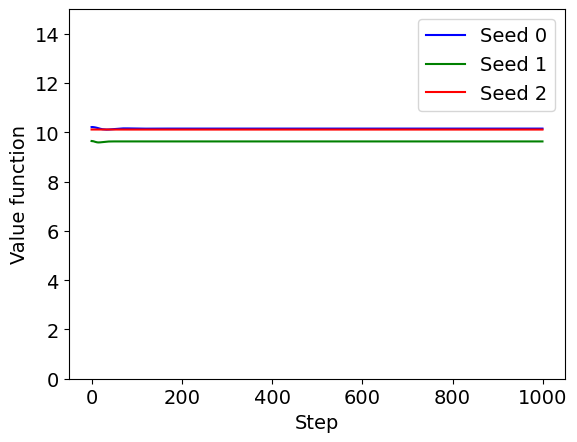

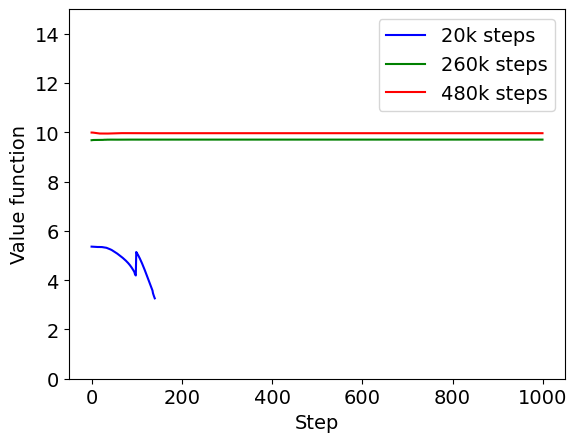

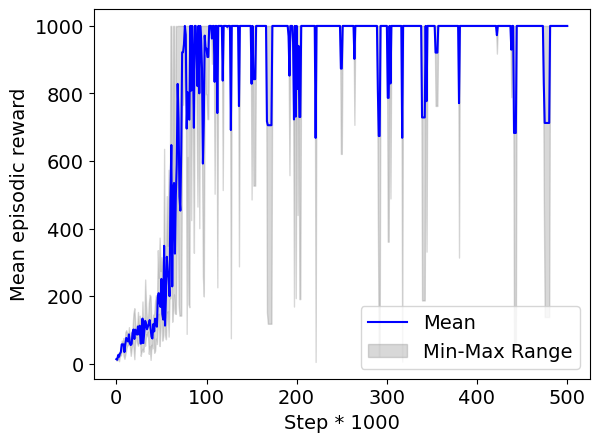

In [13]:
folder_name = 'Results_6env_6step_cont'
plotting(folder_name, seeds)

## Mixing figures so we can fit everything in the report

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
                        
def plotting_n(folder_name, seeds): #function to make all the plots for report
    actors  = []
    critics = []
    rewards_20 = []
    v_values = [[] for _ in range(len(seeds))]
    v0 = []
    v1 = []
    v2 = []
    all_rewards = []
    steps = []
    aggregated_seed = []
    aggregated_seed_steps = []
    colors = ['blue', 'green', 'red']

    actors2  = []
    critics2 = []
    rewards_202 = []
    v_values2 = [[] for _ in range(len(seeds))]
    v02 = []
    v12 = []
    v22 = []
    all_rewards2 = []
    steps2 = []
    aggregated_seed2 = []
    aggregated_seed_steps2 = []
    for i, seed in enumerate(seeds):

        filenames = [os.path.join(folder_name[0], str(seed)+'_1_1k.csv'), os.path.join(folder_name[0], str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name[0], str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name[0], str(seed)+'_1_Ep_Rewards.csv')]
        data1 = pd.read_csv(filenames[0])

        actors.append(data1['Actor loss'])
        critics.append(data1['Critic loss'])

        data2 = pd.read_csv(filenames[1])
        rewards_20.append(data2['Mean episodic reward'])

        data3 = pd.read_csv(filenames[2])

        
        v0.append(data3['V_Values_20000'])  #v_value at begining 
        v1.append(data3['V_Values_260000']) #in the middle
        v2.append(data3['V_Values_480000']) #at the end

        for col in data3.columns:
            v_values[i].append(data3[col].mean())

        data4 = pd.read_csv(filenames[3])
        aggregated = data4.groupby('Step', as_index=False).mean() #in case multiple envs ended at same step, we take the mean
        all_rewards.append(aggregated['Episodic reward'])
        steps.append(aggregated['Step'])

        multiples_of_1000 = list(range(1000, 501001, 1000)) #for aggregating seeds, we take the last value for each of them right before each 1k steps, and we will take the mean, min and max of the seeds
        result = []

        for mult in multiples_of_1000:
            filtered_df = aggregated[aggregated['Step'] < mult]
            if not filtered_df.empty:
                last_value = filtered_df.iloc[-1]['Episodic reward']
                result.append({'step': mult, 'value': last_value})

        result_df = pd.DataFrame(result)

        aggregated_seed.append(result_df['value'])
        aggregated_seed_steps.append(result_df['step'])

        ############################################################

        filenames2 = [os.path.join(folder_name[1], str(seed)+'_1_1k.csv'), os.path.join(folder_name[1], str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name[1], str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name[1], str(seed)+'_1_Ep_Rewards.csv')]
        data12 = pd.read_csv(filenames2[0])

        actors2.append(data12['Actor loss'])
        critics2.append(data12['Critic loss'])

        data22 = pd.read_csv(filenames2[1])
        rewards_202.append(data22['Mean episodic reward'])

        data32 = pd.read_csv(filenames2[2])

        
        v02.append(data32['V_Values_20000'])  #v_value at begining 
        v12.append(data32['V_Values_260000']) #in the middle
        v22.append(data32['V_Values_480000']) #at the end

        for col in data32.columns:
            v_values2[i].append(data32[col].mean())

        data42 = pd.read_csv(filenames2[3])
        aggregated2 = data42.groupby('Step', as_index=False).mean() #in case multiple envs ended at same step, we take the mean
        all_rewards2.append(aggregated2['Episodic reward'])
        steps2.append(aggregated2['Step'])

        multiples_of_1000 = list(range(1000, 501001, 1000)) #for aggregating seeds, we take the last value for each of them right before each 1k steps, and we will take the mean, min and max of the seeds
        result2 = []

        for mult in multiples_of_1000:
            filtered_df2 = aggregated2[aggregated2['Step'] < mult]
            if not filtered_df2.empty:
                last_value2 = filtered_df2.iloc[-1]['Episodic reward']
                result2.append({'step': mult, 'value': last_value2})

        result_df2 = pd.DataFrame(result2)

        aggregated_seed2.append(result_df2['value'])
        aggregated_seed_steps2.append(result_df2['step'])

    mean_actors = np.mean(actors, axis=0)
    mean_critics = np.mean(critics, axis=0)
    mean_rewards20 = np.mean(rewards_20, axis=0)
    mean_vs = np.mean(v_values, axis=0)
    mean_aggr = np.mean(aggregated_seed, axis = 0)
    mean_v0 = np.nanmean(v0, axis=0)
    mean_v1 = np.nanmean(v1, axis=0)
    mean_v2 = np.nanmean(v2, axis=0)

    max_actors = np.max(actors, axis=0)
    max_critics = np.max(critics, axis=0)
    max_rewards20 = np.max(rewards_20, axis=0)
    max_aggr = np.max(aggregated_seed, axis = 0)

    min_actors = np.min(actors, axis=0)
    min_critics = np.min(critics, axis=0)
    min_rewards20 = np.min(rewards_20, axis=0)
    min_aggr = np.min(aggregated_seed, axis=0)

    mean_actors2 = np.mean(actors2, axis=0)
    mean_critics2 = np.mean(critics2, axis=0)
    mean_rewards202 = np.mean(rewards_202, axis=0)
    mean_vs2 = np.mean(v_values2, axis=0)
    mean_aggr2 = np.mean(aggregated_seed2, axis = 0)
    mean_v02 = np.nanmean(v02, axis=0)
    mean_v12 = np.nanmean(v12, axis=0)
    mean_v22 = np.nanmean(v22, axis=0)

    max_actors2 = np.max(actors2, axis=0)
    max_critics2 = np.max(critics2, axis=0)
    max_rewards202 = np.max(rewards_202, axis=0)
    max_aggr2 = np.max(aggregated_seed2, axis = 0)

    min_actors2 = np.min(actors2, axis=0)
    min_critics2 = np.min(critics2, axis=0)
    min_rewards202 = np.min(rewards_202, axis=0)
    min_aggr2 = np.min(aggregated_seed2, axis=0)


    plt.plot(range(len(mean_actors)), mean_actors, color='blue', marker='x', linestyle='', label='Mean - K=1, n=1')
    plt.fill_between(range(len(mean_actors)), min_actors, max_actors, color='blue', alpha=0.3, label='Min-Max Range')
    plt.plot(range(len(mean_actors2)), mean_actors2, color='red', marker='x', linestyle='', label='Mean - K=6, n=6')
    plt.fill_between(range(len(mean_actors2)), min_actors2, max_actors2, color='red', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Actor loss')
    plt.legend(fontsize='medium')
    plt.savefig('Actor_cont.jpg', dpi=300)

    plt.figure()
    plt.plot(range(len(mean_critics)), mean_critics, color='blue', marker='x', label='Mean - K=1, n=1')
    plt.fill_between(range(len(mean_critics)), min_critics, max_critics, color='blue', alpha=0.3, label='Min-Max Range')
    plt.plot(range(len(mean_critics2)), mean_critics2, color='red', marker='x', label='Mean - K=6, n=6')
    plt.fill_between(range(len(mean_critics2)), min_critics2, max_critics2, color='red', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Critic loss')
    plt.legend(fontsize=11)
    plt.savefig('Critic_cont.jpg', dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards20)), mean_rewards20, color='blue', label='Mean - K=1, n=1')
    plt.fill_between(range(len(mean_rewards20)), min_rewards20, max_rewards20, color='blue', alpha=0.3, label='Min-Max Range')
    plt.plot(range(len(mean_rewards202)), mean_rewards202, color='red', label='Mean - K=6, n=6')
    plt.fill_between(range(len(mean_rewards202)), min_rewards202, max_rewards202, color='red', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 20000')
    plt.ylabel('Mean episodic reward')
    plt.legend(fontsize='small')
    plt.savefig('Rewards_20k_cont.jpg', dpi=300)

    plt.figure()
    plt.plot(range(len(mean_vs)), mean_vs, color='blue', label='K=1, n=1')
    plt.plot(range(len(mean_vs2)), mean_vs2, color='red', label='K=6, n=6')
    plt.xlabel('Step * 20000')
    plt.ylabel('Value function')
    plt.legend(fontsize='small')
    plt.savefig('V_values_cont.jpg', dpi=300)

    plt.figure()
    plt.plot(range(len(mean_v0)), mean_v0, color=colors[0], label='20k steps - K=1, n=1')
    plt.plot(range(len(mean_v02)), mean_v02, color=colors[0], linestyle = '--', label='20k steps - K=6, n=6')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,15)

    plt.plot(range(len(mean_v1)), mean_v1, color=colors[1], label='260k steps - K=1, n=1')
    plt.plot(range(len(mean_v12)), mean_v12, color=colors[1], linestyle='--', label='260k steps - K=6, n=6')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,15)

    plt.plot(range(len(mean_v2)), mean_v2, color=colors[2], label='480k steps - K=1, n=1')
    plt.plot(range(len(mean_v22)), mean_v22, color=colors[2], linestyle='--', label='480k steps - K=6, n=6')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,15)

    plt.legend(fontsize='small')
    plt.savefig('V_values_mean_cont.jpg', dpi=300)

    
    plt.figure()
    plt.plot(range(len(mean_aggr)), mean_aggr, color='blue', label='Mean - K=1, n=1')
    plt.fill_between(range(len(mean_aggr)), min_aggr, max_aggr, color='blue', alpha=0.3, label='Min-Max Range')
    plt.plot(range(len(mean_aggr2)), mean_aggr2, color='red', label='Mean - K=6, n=6')
    plt.fill_between(range(len(mean_aggr2)), min_aggr2, max_aggr2, color='red', alpha=0.3, label='Min-Max Range')
    plt.xlabel('Step * 1000')
    plt.ylabel('Mean episodic reward')
    plt.legend(fontsize='small')
    plt.savefig('Rewards_Aggr_cont.jpg', dpi=300)

/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_83294/2892890676.py:117: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)
/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_83294/2892890676.py:136: RuntimeWarning: Mean of empty slice
  mean_v02 = np.nanmean(v02, axis=0)


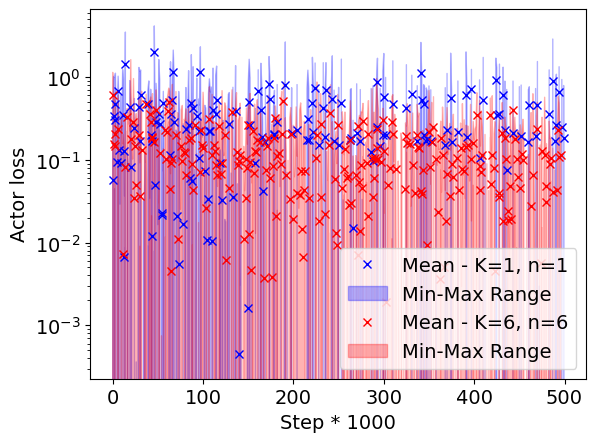

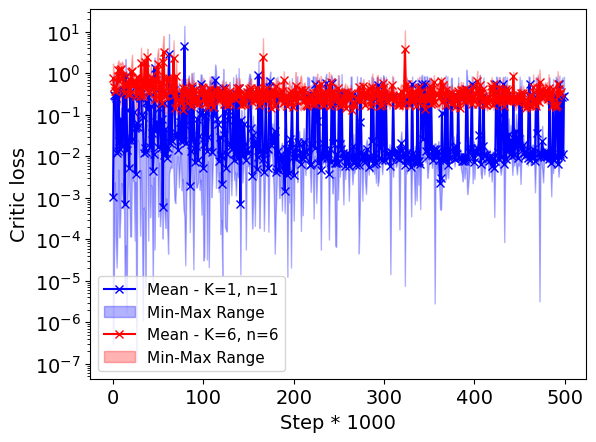

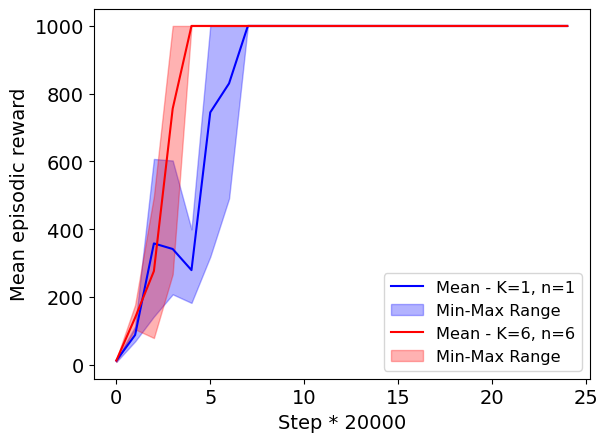

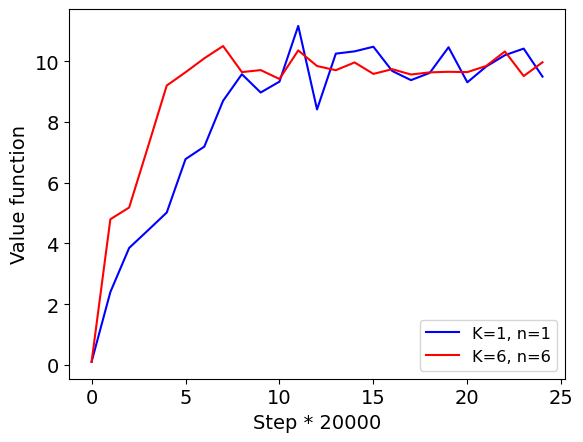

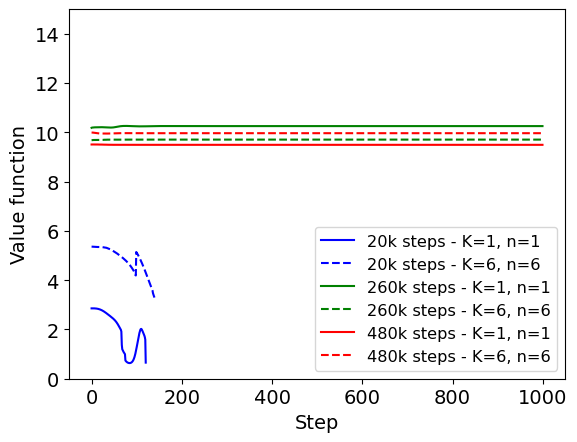

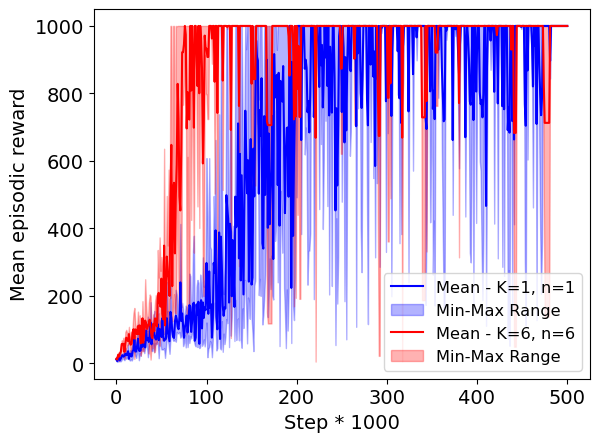

In [33]:
folders = ['Results_1env_1step_cont', 'Results_6env_6step_cont']
seeds = [52, 123, 89]
plotting_n(folders, seeds)

/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_83294/1194555378.py:117: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)
/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_83294/1194555378.py:136: RuntimeWarning: Mean of empty slice
  mean_v02 = np.nanmean(v02, axis=0)


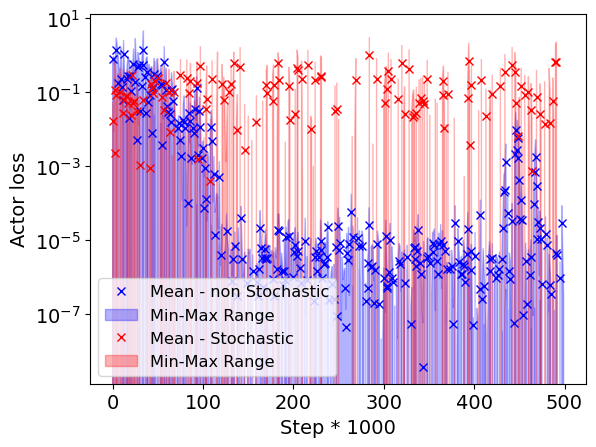

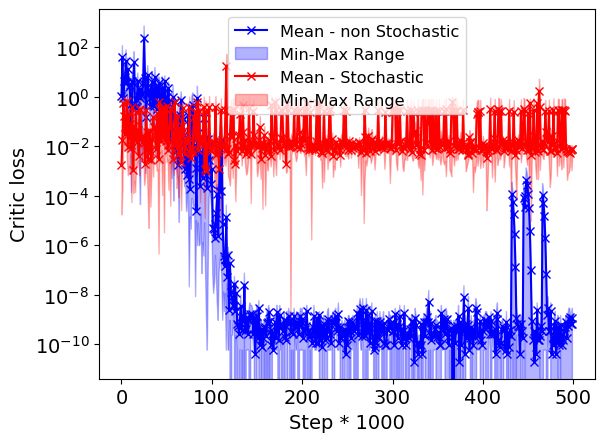

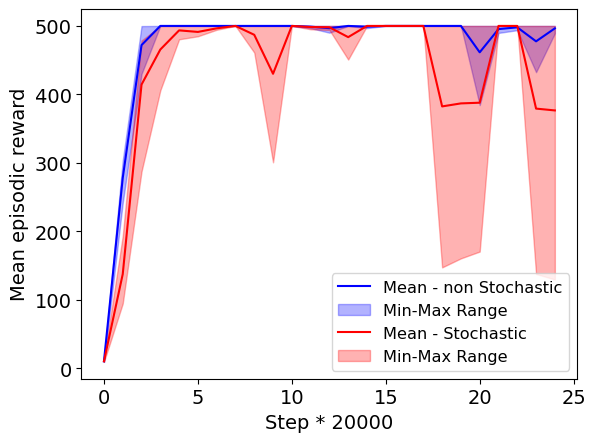

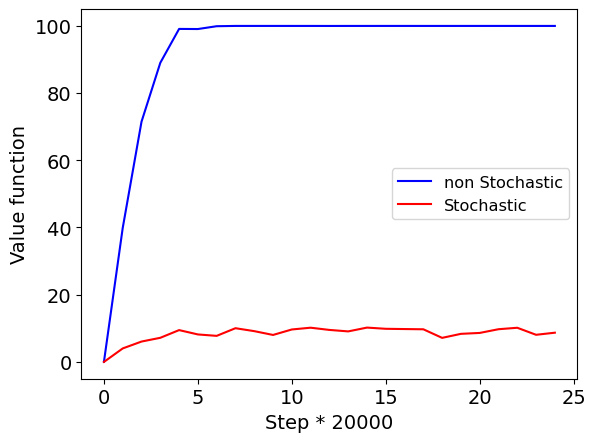

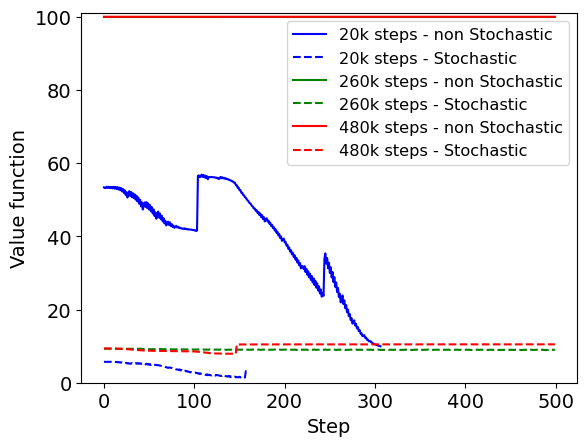

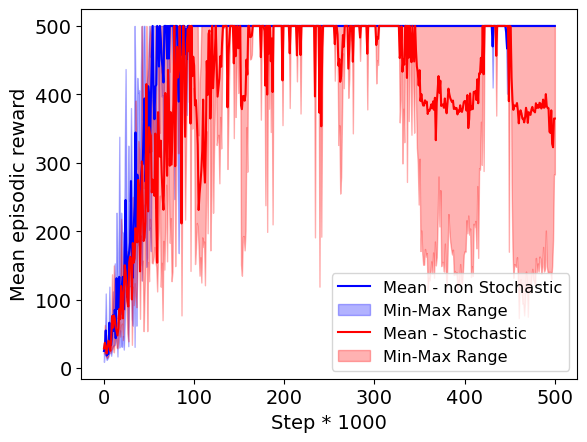

In [19]:
folders = ['Results_1_1_nonSparse_redo', 'Results_1_1_Sparse']
seeds = [52, 123, 89]
plotting_n(folders, seeds)

## Trying K=1 and n=1 with a higher actor lr

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1env_1step_cont_highlr'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=True, continuous=True, lr_actor=3e-4)

  0%|          | 32/500000 [00:00<48:28, 171.88it/s]

episodic return of the 20000: 17.0


  4%|▍         | 20026/500000 [01:16<4:05:51, 32.54it/s]

episodic return of the 20000: 1000.0


  8%|▊         | 40035/500000 [02:22<3:20:06, 38.31it/s] 

episodic return of the 20000: 1000.0


 12%|█▏        | 60030/500000 [03:39<3:32:19, 34.54it/s] 

episodic return of the 20000: 1000.0


 16%|█▌        | 80052/500000 [05:07<2:17:17, 50.98it/s] 

episodic return of the 20000: 1000.0


 20%|██        | 100045/500000 [06:35<38:54, 171.30it/s] 

episodic return of the 20000: 68.4


 24%|██▍       | 120024/500000 [08:27<5:34:53, 18.91it/s] 

episodic return of the 20000: 1000.0


 28%|██▊       | 140042/500000 [10:03<1:59:22, 50.26it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 160029/500000 [11:58<38:14, 148.19it/s] 

episodic return of the 20000: 3.0


 36%|███▌      | 180043/500000 [13:30<19:53, 268.02it/s]

episodic return of the 20000: 3.0


 40%|████      | 200048/500000 [14:52<19:35, 255.07it/s]

episodic return of the 20000: 3.0


 44%|████▍     | 220039/500000 [16:19<16:54, 275.91it/s]

episodic return of the 20000: 3.0


 48%|████▊     | 240039/500000 [17:44<15:16, 283.58it/s]

episodic return of the 20000: 3.0


 52%|█████▏    | 260033/500000 [19:08<15:06, 264.68it/s]

episodic return of the 20000: 3.0


 56%|█████▌    | 280049/500000 [20:40<15:04, 243.12it/s]

episodic return of the 20000: 3.0


 60%|██████    | 300031/500000 [22:03<15:00, 222.07it/s]

episodic return of the 20000: 3.0


 64%|██████▍   | 320025/500000 [23:33<13:44, 218.24it/s]

episodic return of the 20000: 3.0


 68%|██████▊   | 340041/500000 [24:59<11:53, 224.31it/s]

episodic return of the 20000: 3.0


 72%|███████▏  | 360031/500000 [26:26<11:28, 203.31it/s]

episodic return of the 20000: 3.0


 76%|███████▌  | 380026/500000 [27:51<11:45, 170.01it/s]

episodic return of the 20000: 3.0


 80%|████████  | 400041/500000 [29:21<07:12, 231.24it/s]

episodic return of the 20000: 3.0


 84%|████████▍ | 420026/500000 [30:47<07:13, 184.46it/s]

episodic return of the 20000: 3.0


 88%|████████▊ | 440032/500000 [32:20<04:34, 218.72it/s]

episodic return of the 20000: 3.0


 92%|█████████▏| 460026/500000 [33:50<04:35, 145.04it/s]

episodic return of the 20000: 3.0


 96%|█████████▌| 480036/500000 [35:25<01:40, 199.47it/s]

episodic return of the 20000: 3.0


  0%|          | 43/500000 [00:00<37:29, 222.28it/s]

episodic return of the 20000: 8.7


  4%|▍         | 20064/500000 [01:09<2:17:28, 58.19it/s]

episodic return of the 20000: 1000.0


  8%|▊         | 40033/500000 [02:16<56:00, 136.87it/s]  

episodic return of the 20000: 255.5


 12%|█▏        | 60068/500000 [03:18<27:56, 262.34it/s]

episodic return of the 20000: 55.9


 16%|█▌        | 80049/500000 [04:27<2:30:19, 46.56it/s]

episodic return of the 20000: 1000.0


 20%|██        | 100035/500000 [05:35<2:14:35, 49.53it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 120066/500000 [06:40<1:36:54, 65.35it/s] 

episodic return of the 20000: 1000.0


 28%|██▊       | 140040/500000 [07:46<1:50:56, 54.08it/s] 

episodic return of the 20000: 1000.0


 32%|███▏      | 160035/500000 [08:52<1:30:05, 62.90it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 180044/500000 [09:58<1:34:54, 56.19it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200050/500000 [11:04<1:31:06, 54.87it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 220044/500000 [12:11<1:16:34, 60.94it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 240038/500000 [13:20<19:47, 218.88it/s] 

episodic return of the 20000: 122.9


 52%|█████▏    | 260047/500000 [14:21<56:44, 70.48it/s]  

episodic return of the 20000: 1000.0


 56%|█████▌    | 280041/500000 [15:21<52:13, 70.20it/s]  

episodic return of the 20000: 1000.0


 60%|██████    | 300052/500000 [16:20<46:42, 71.34it/s]  

episodic return of the 20000: 1000.0


 64%|██████▍   | 320069/500000 [17:20<42:12, 71.05it/s] 

episodic return of the 20000: 1000.0


 68%|██████▊   | 340035/500000 [18:38<1:06:33, 40.05it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 360039/500000 [19:56<55:04, 42.36it/s]  

episodic return of the 20000: 1000.0


 76%|███████▌  | 380025/500000 [21:28<1:15:50, 26.37it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 400040/500000 [23:00<45:30, 36.61it/s]  

episodic return of the 20000: 1000.0


 84%|████████▍ | 420024/500000 [24:30<49:06, 27.14it/s]  

episodic return of the 20000: 1000.0


 88%|████████▊ | 440030/500000 [25:59<30:07, 33.17it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460021/500000 [27:27<27:25, 24.29it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480033/500000 [28:54<10:10, 32.70it/s] 

episodic return of the 20000: 1000.0


  0%|          | 25/500000 [00:00<1:00:05, 138.68it/s]

episodic return of the 20000: 12.5


  4%|▍         | 20019/500000 [01:24<9:07:33, 14.61it/s]

episodic return of the 20000: 1000.0


  8%|▊         | 40035/500000 [03:15<5:27:14, 23.43it/s] 

episodic return of the 20000: 1000.0


 12%|█▏        | 60034/500000 [05:06<1:11:04, 103.16it/s]

episodic return of the 20000: 110.9


 16%|█▌        | 80019/500000 [06:47<3:40:19, 31.77it/s] 

episodic return of the 20000: 1000.0


 20%|██        | 100039/500000 [08:17<3:11:22, 34.83it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 120050/500000 [09:38<26:30, 238.96it/s]  

episodic return of the 20000: 3.0


 28%|██▊       | 140046/500000 [11:06<23:54, 250.98it/s]

episodic return of the 20000: 3.0


 32%|███▏      | 160033/500000 [12:33<26:51, 211.03it/s]

episodic return of the 20000: 3.0


 36%|███▌      | 180030/500000 [13:58<22:13, 239.92it/s]

episodic return of the 20000: 3.0


 40%|████      | 200006/500000 [15:24<21:25, 233.37it/s]

episodic return of the 20000: 3.0


 44%|████▍     | 220028/500000 [16:50<19:49, 235.29it/s]

episodic return of the 20000: 3.0


 48%|████▊     | 240027/500000 [18:16<18:38, 232.38it/s]

episodic return of the 20000: 3.0


 52%|█████▏    | 260045/500000 [19:42<18:41, 214.05it/s]

episodic return of the 20000: 3.0


 56%|█████▌    | 280041/500000 [21:12<17:43, 206.90it/s]

episodic return of the 20000: 3.0


 60%|██████    | 300031/500000 [22:45<14:39, 227.29it/s]

episodic return of the 20000: 3.0


 64%|██████▍   | 320037/500000 [24:20<15:48, 189.65it/s]

episodic return of the 20000: 3.0


 68%|██████▊   | 340025/500000 [26:04<12:08, 219.62it/s]

episodic return of the 20000: 3.0


 72%|███████▏  | 360025/500000 [27:41<11:18, 206.27it/s]

episodic return of the 20000: 3.0


 76%|███████▌  | 380044/500000 [29:23<09:20, 213.94it/s]

episodic return of the 20000: 3.0


 80%|████████  | 400028/500000 [31:05<08:04, 206.29it/s]

episodic return of the 20000: 3.0


 84%|████████▍ | 420027/500000 [33:04<08:08, 163.62it/s]

episodic return of the 20000: 3.0


 88%|████████▊ | 440019/500000 [35:19<08:23, 119.16it/s]

episodic return of the 20000: 3.0


 92%|█████████▏| 460014/500000 [37:48<05:43, 116.37it/s]

episodic return of the 20000: 3.0


 96%|█████████▌| 480022/500000 [41:11<01:57, 170.38it/s] 

episodic return of the 20000: 3.0


100%|██████████| 500000/500000 [42:49<00:00, 194.60it/s]


[-0.06995151210526315, 8.4010061585, 9.140953263500004, 9.178504548000001, 9.070565126, 3.334011055844156, 8.89493347, 10.664730446000002, 0.11715126933333335, 0.23897057666666666, 0.032692884666666665, 0.35514538, 0.5113306000000001, 0.17653823333333332, 0.22439106500000003, -0.04785355599999999, 0.39621454666666667, 0.04024085533333333, 0.13779126866666666, -0.019331994100000003, 0.13279559233333335, 0.17217478866666666, 0.27951666000000003, 0.07568620033333333, 0.1599694093333333]


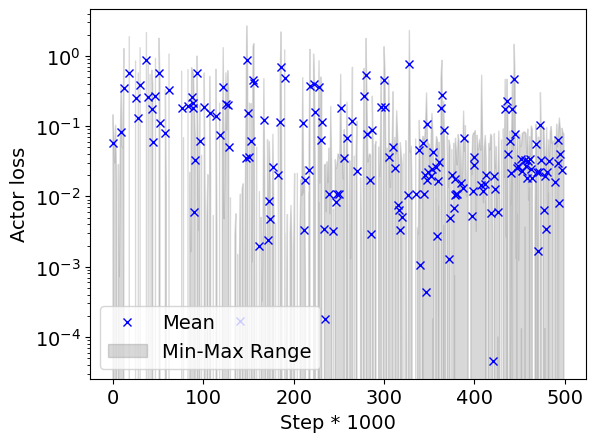

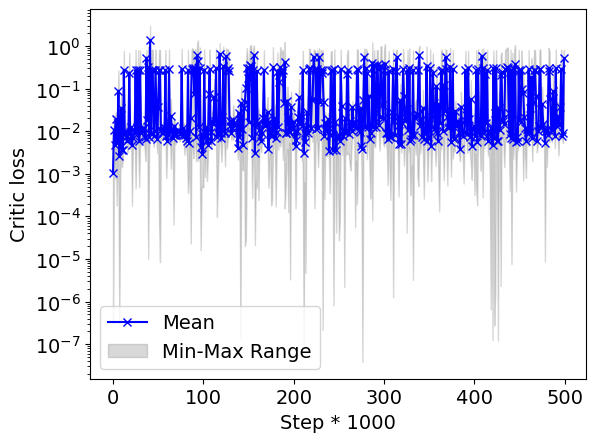

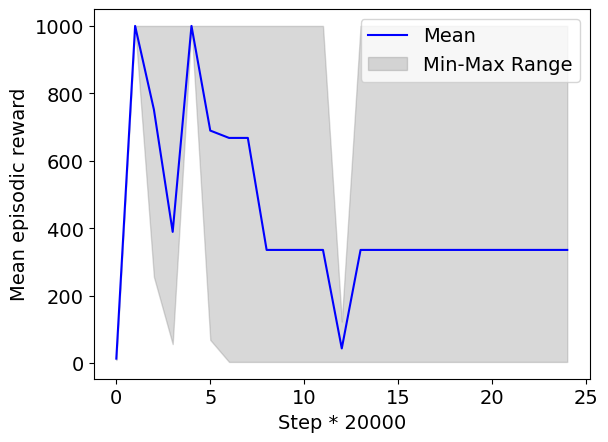

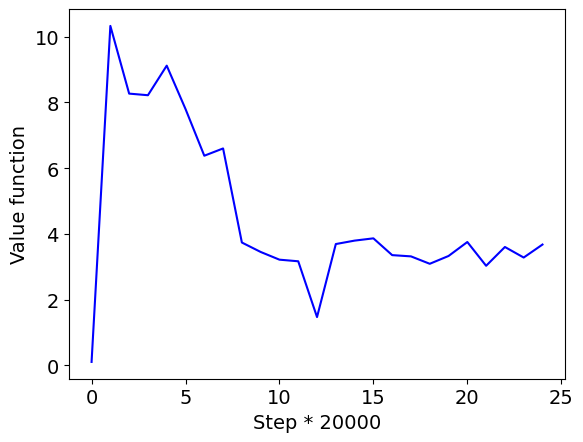

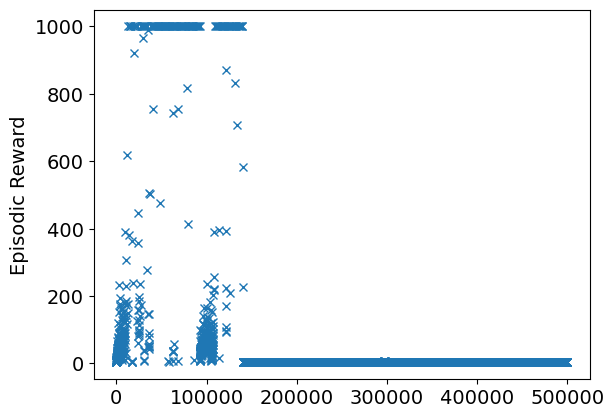

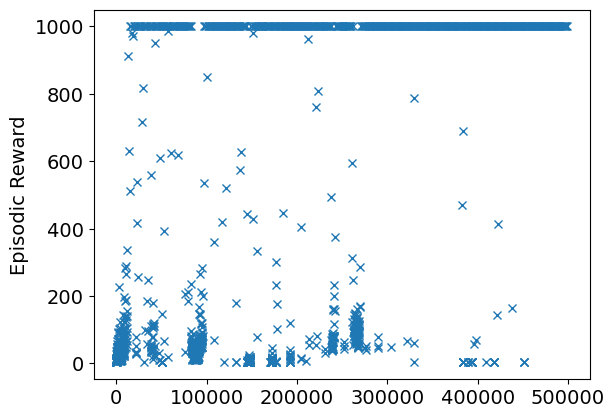

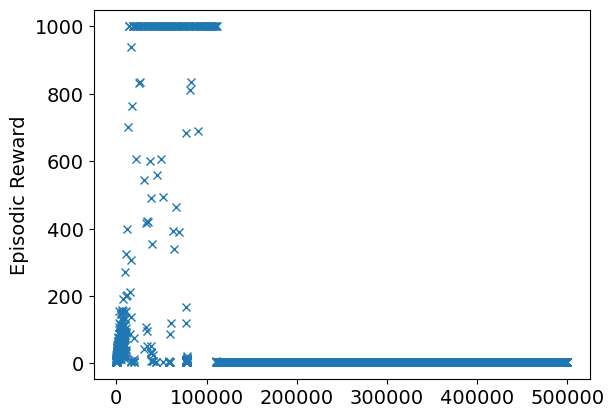

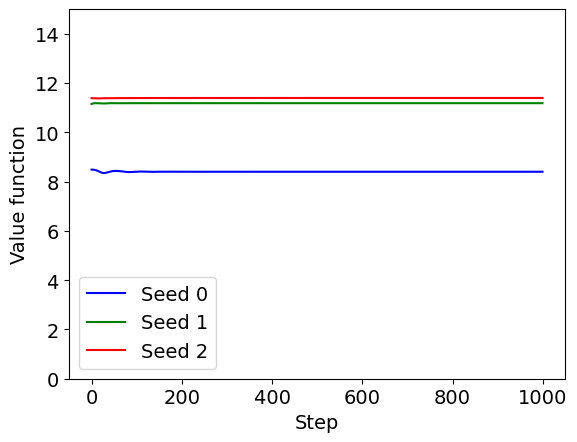

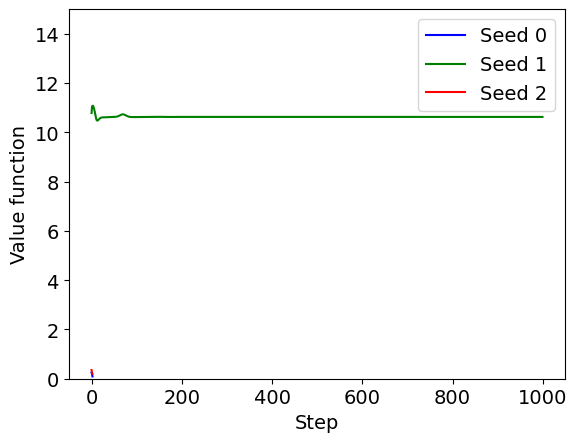

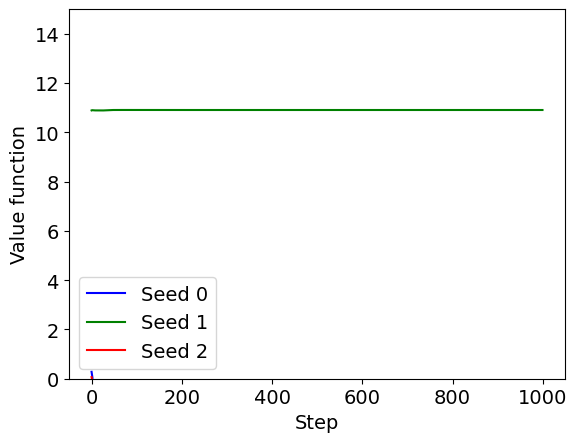

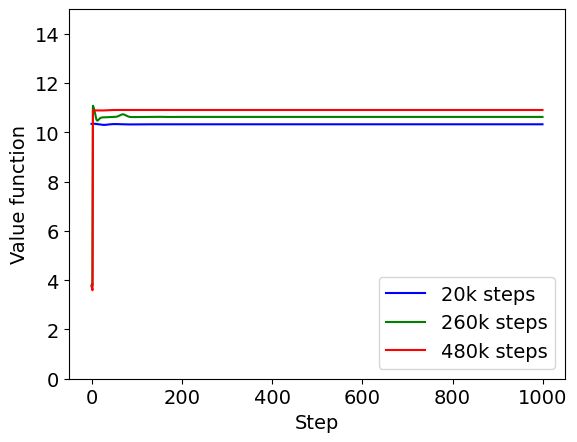

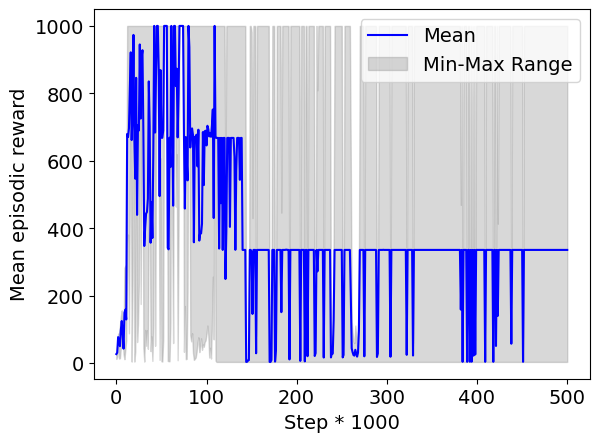

In [12]:
folder_name = 'Results_1env_1step_cont_highlr'
plotting(folder_name, seeds)

## Agent 0 with bad bootstrap : not making a difference between terminated and truncated

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1_1_nonSparse_wrongboot'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=False)

  0%|          | 0/500000 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 20/500000 [00:00<1:17:18, 107.78it/s]

episodic return of the 20000: 9.2


  4%|▍         | 20034/500000 [01:35<1:24:26, 94.73it/s] 

episodic return of the 20000: 244.5


  8%|▊         | 40019/500000 [03:02<2:10:16, 58.85it/s] 

episodic return of the 20000: 499.8


 12%|█▏        | 60005/500000 [04:27<1:54:33, 64.01it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80029/500000 [05:49<1:30:37, 77.24it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100018/500000 [07:13<1:54:14, 58.35it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120018/500000 [08:34<1:54:57, 55.09it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 140012/500000 [10:01<1:32:13, 65.05it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160021/500000 [11:30<1:58:54, 47.65it/s]

episodic return of the 20000: 500.0


 36%|███▌      | 180026/500000 [12:53<1:34:16, 56.56it/s]

episodic return of the 20000: 500.0


 40%|████      | 200016/500000 [14:19<1:35:18, 52.46it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220037/500000 [15:50<1:44:29, 44.66it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240018/500000 [17:08<1:09:48, 62.06it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 260041/500000 [18:28<59:20, 67.39it/s]  

episodic return of the 20000: 482.9


 56%|█████▌    | 280033/500000 [19:53<1:32:43, 39.54it/s]

episodic return of the 20000: 500.0


 60%|██████    | 300004/500000 [21:14<48:42, 68.43it/s]  

episodic return of the 20000: 489.4


 64%|██████▍   | 320026/500000 [22:34<45:30, 65.91it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340022/500000 [23:56<36:54, 72.26it/s] 

episodic return of the 20000: 495.1


 72%|███████▏  | 360025/500000 [25:22<38:35, 60.45it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380024/500000 [26:51<39:55, 50.07it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400021/500000 [28:18<28:18, 58.88it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 420025/500000 [29:37<22:51, 58.32it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440012/500000 [31:06<19:27, 51.40it/s] 

episodic return of the 20000: 497.6


 92%|█████████▏| 460024/500000 [32:34<11:11, 59.51it/s] 

episodic return of the 20000: 493.3


 96%|█████████▌| 480017/500000 [34:04<06:03, 54.99it/s] 

episodic return of the 20000: 459.1


  0%|          | 37/500000 [00:00<42:49, 194.57it/s]  

episodic return of the 20000: 13.2


  4%|▍         | 20027/500000 [01:24<1:19:05, 101.14it/s]

episodic return of the 20000: 304.0


  8%|▊         | 40026/500000 [02:53<3:17:16, 38.86it/s] 

episodic return of the 20000: 500.0


 12%|█▏        | 60000/500000 [04:17<28:21, 258.61it/s]  

episodic return of the 20000: 495.1


 16%|█▌        | 80011/500000 [05:40<1:57:02, 59.81it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100021/500000 [07:04<1:35:52, 69.54it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 119999/500000 [08:23<24:10, 261.97it/s] 

episodic return of the 20000: 490.4


 28%|██▊       | 140007/500000 [09:50<1:48:47, 55.15it/s]

episodic return of the 20000: 500.0


 32%|███▏      | 160020/500000 [11:20<1:27:36, 64.68it/s]

episodic return of the 20000: 491.2


 36%|███▌      | 180044/500000 [12:46<1:39:11, 53.76it/s]

episodic return of the 20000: 495.1


 40%|████      | 200033/500000 [14:16<1:18:02, 64.06it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220010/500000 [15:42<1:19:37, 58.60it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240026/500000 [17:14<1:29:12, 48.57it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 260020/500000 [18:40<58:59, 67.81it/s]  

episodic return of the 20000: 500.0


 56%|█████▌    | 280018/500000 [20:00<59:07, 62.01it/s] 

episodic return of the 20000: 500.0


 60%|██████    | 300027/500000 [21:23<41:21, 80.59it/s] 

episodic return of the 20000: 462.4


 64%|██████▍   | 320011/500000 [22:43<50:05, 59.89it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340014/500000 [24:08<44:16, 60.22it/s] 

episodic return of the 20000: 500.0


 72%|███████▏  | 360026/500000 [25:28<34:54, 66.84it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380016/500000 [26:48<32:31, 61.48it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400020/500000 [28:09<24:35, 67.77it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 420025/500000 [30:00<34:52, 38.21it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440025/500000 [31:53<14:04, 71.01it/s] 

episodic return of the 20000: 250.2


 92%|█████████▏| 460039/500000 [33:51<13:27, 49.49it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480023/500000 [35:55<12:48, 26.00it/s] 

episodic return of the 20000: 500.0


  0%|          | 25/500000 [00:00<1:04:27, 129.26it/s]

episodic return of the 20000: 9.4


  4%|▍         | 20014/500000 [02:26<4:36:32, 28.93it/s] 

episodic return of the 20000: 324.1


  8%|▊         | 40044/500000 [04:09<2:23:49, 53.30it/s] 

episodic return of the 20000: 460.8


 12%|█▏        | 60010/500000 [05:44<2:03:15, 59.49it/s] 

episodic return of the 20000: 394.4


 16%|█▌        | 80046/500000 [07:11<1:36:22, 72.63it/s] 

episodic return of the 20000: 483.7


 20%|██        | 100023/500000 [08:40<2:10:56, 50.91it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120030/500000 [10:07<1:28:45, 71.35it/s] 

episodic return of the 20000: 497.5


 28%|██▊       | 140035/500000 [11:35<1:25:46, 69.94it/s]

episodic return of the 20000: 491.7


 32%|███▏      | 160036/500000 [13:02<1:26:21, 65.61it/s]

episodic return of the 20000: 490.5


 36%|███▌      | 180030/500000 [14:29<1:18:21, 68.05it/s]

episodic return of the 20000: 500.0


 40%|████      | 200023/500000 [15:57<1:35:39, 52.27it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220049/500000 [17:24<1:05:29, 71.24it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240032/500000 [18:52<1:02:06, 69.77it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 260040/500000 [20:20<57:19, 69.77it/s]  

episodic return of the 20000: 498.5


 56%|█████▌    | 280038/500000 [21:47<1:00:23, 60.71it/s]

episodic return of the 20000: 500.0


 60%|██████    | 300040/500000 [23:23<48:17, 69.00it/s]  

episodic return of the 20000: 500.0


 64%|██████▍   | 320024/500000 [25:08<58:25, 51.34it/s]  

episodic return of the 20000: 500.0


 68%|██████▊   | 340029/500000 [26:55<47:38, 55.96it/s]  

episodic return of the 20000: 500.0


 72%|███████▏  | 360043/500000 [28:39<41:11, 56.63it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380016/500000 [30:18<55:14, 36.20it/s] 

episodic return of the 20000: 490.7


 80%|████████  | 400039/500000 [31:58<23:25, 71.11it/s] 

episodic return of the 20000: 483.2


 84%|████████▍ | 420034/500000 [33:27<18:36, 71.60it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440029/500000 [34:55<16:02, 62.32it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460045/500000 [36:22<09:25, 70.64it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480033/500000 [37:49<04:48, 69.26it/s] 

episodic return of the 20000: 500.0


100%|██████████| 500000/500000 [39:09<00:00, 212.83it/s]


[0.09696330665, 46.85152364350453, 80.39730197200001, 84.98626948799999, 84.09488902999999, 85.657011644, 84.65859104, 84.44190296400001, 84.46722759200001, 85.03389999999999, 84.24666599999999, 82.72870999999999, 79.472992578, 85.003243024, 84.81941460799999, 83.95394591800002, 83.79919943, 83.846512774, 83.91315409, 84.755083278, 83.971, 84.18931599999999, 83.46642019199999, 83.656823144, 69.94353459969788]


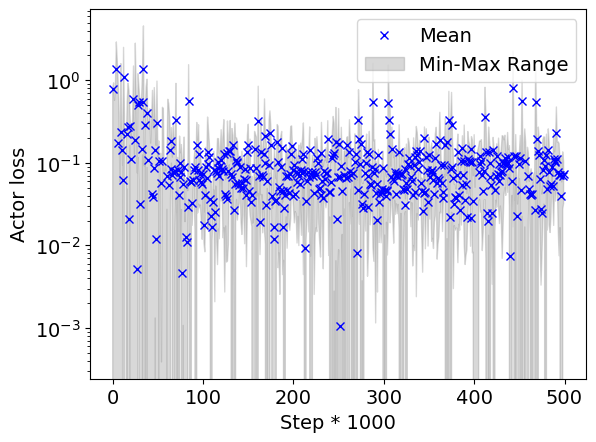

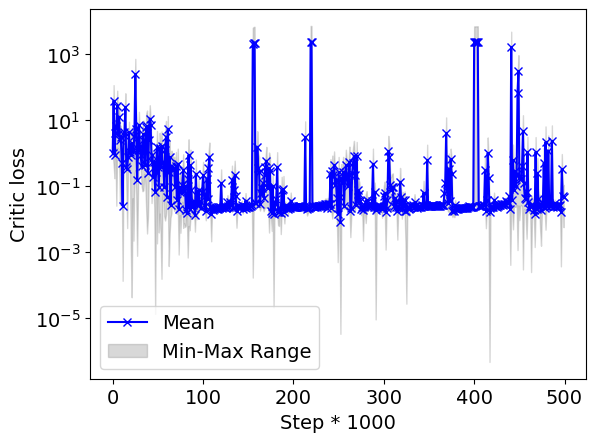

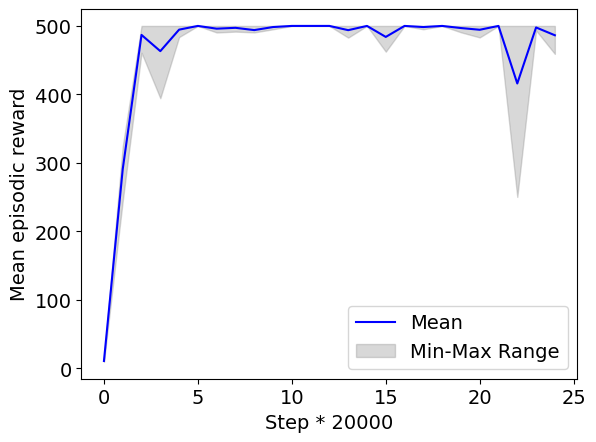

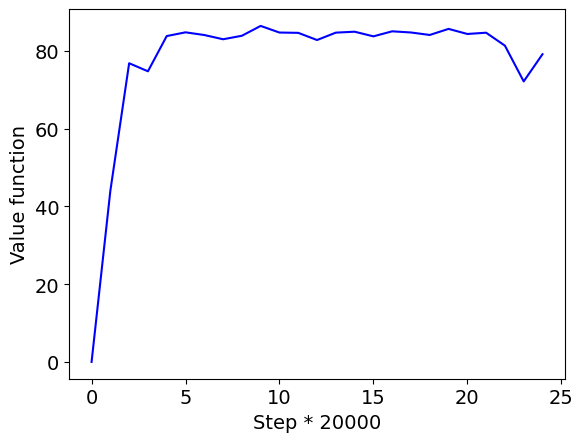

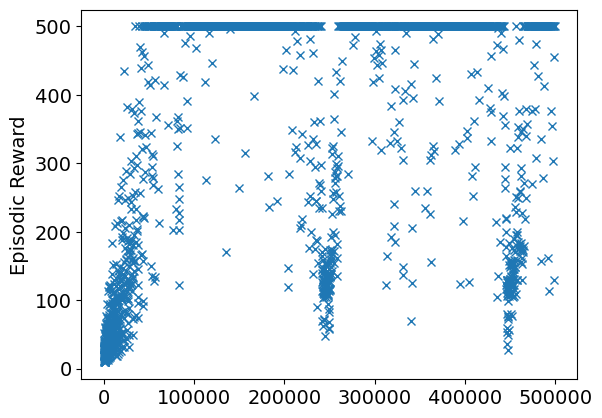

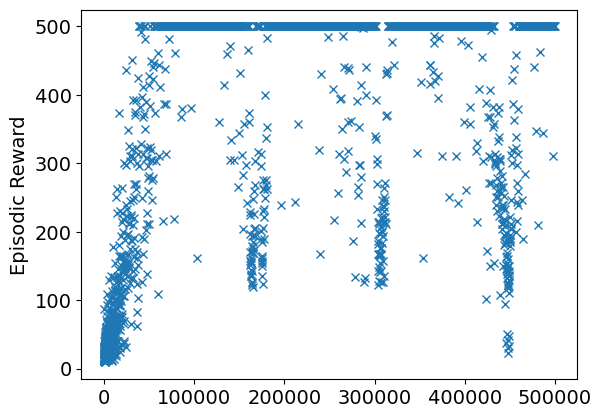

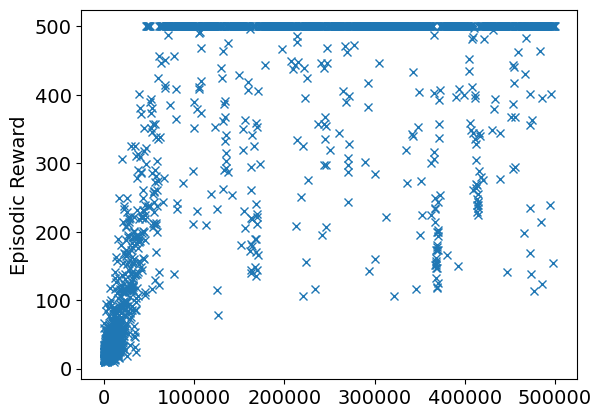

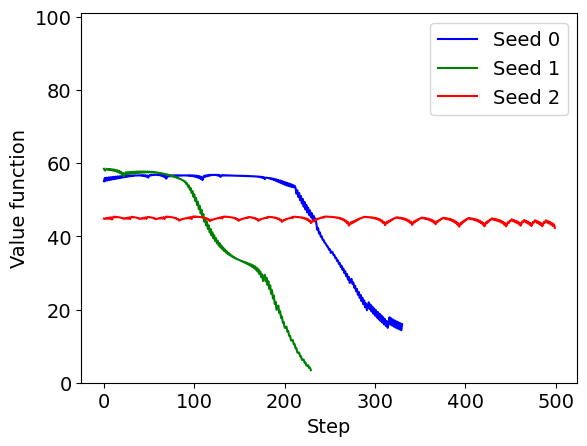

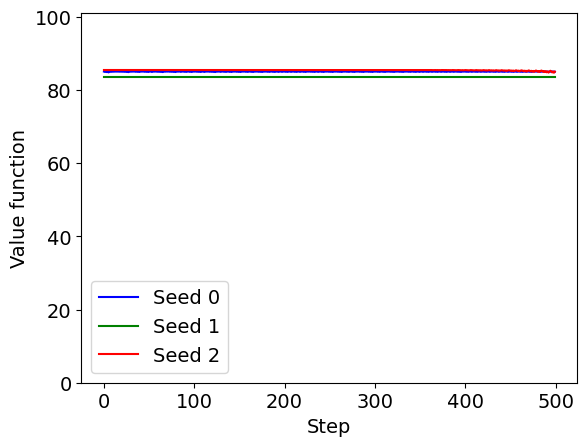

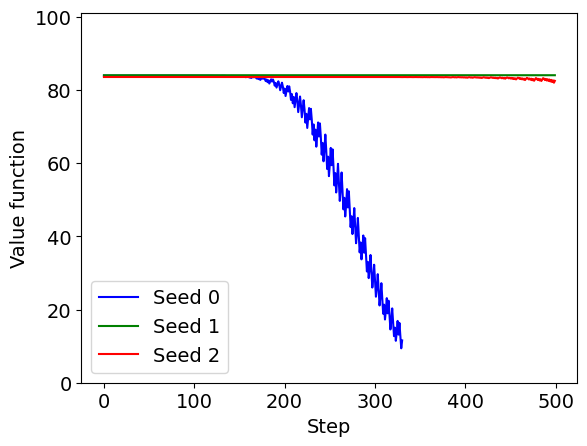

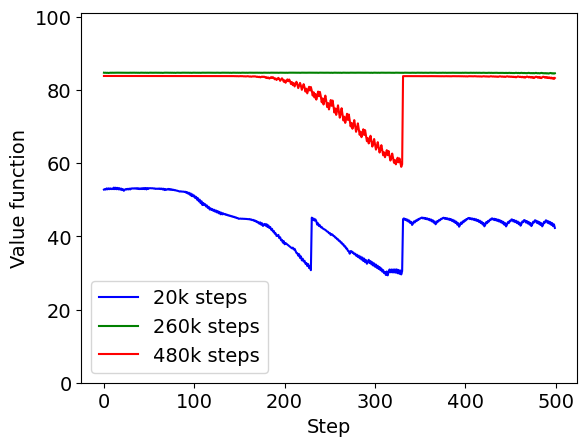

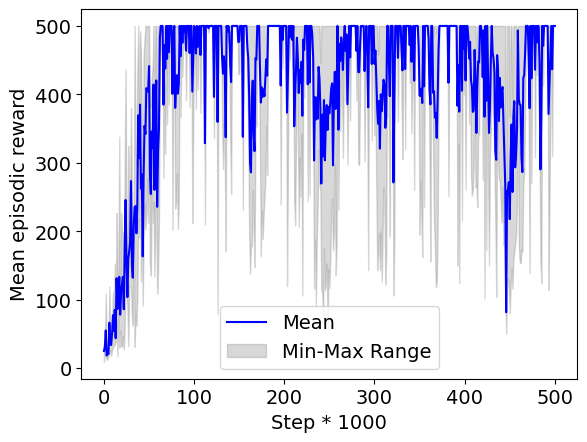

In [14]:
folder_name = 'Results_1_1_nonSparse_wrongboot'
plotting(folder_name, seeds)